# Unsupervised Anomaly Detection on Time Series
## Large Scale Machine Learning Challenge

Sonia BOUDEN


&nbsp;


  **Abstract**:
> Unsupervised anomaly/outlier detection on multidimensional time series data comprises the machine learning methods aimed at identification of observations that exhibit suspicious behaviour and are very likely to cause a problem. In the **unsupervised learning** framework, no label indicating whether a training observation is anomalous or not is available. Hence, anomalies should be identified by learning the normal behavior, and considering those which are significantly different from it as abnormal.

&nbsp; ---



**Properties of the dataset**:


&nbsp;The data set is provided by the Airbus and consistst of the measures of the accelerometer of helicopters during 1 minute at frequency 1024 Hertz, which yields time series measured at in total 60 * 1024 = 61440 equidistant time points.
- Training data:
The training set consists of one file, airbus_train.csv. File airbus_train.csv contains one observation per row, each observation having 61440 entries, measures with equivalent time distance of 1 / 1024 seconds.
There are in total 1677 training observations.
- Test data: The training set consists of one file, airbus_test.csv, which has the same structure as file airbus_train.csv. There are in total 2511 test observations.



&nbsp; ---

**Numerical Performance Criteria**


In the litterature, two functional criteria are used: the **Mass-
Volume (MV)** (Clémençon & Jakubowicz, 2013) and the **Excess-Mass (EM)** (Goix et al., 2015) curves.
The main advantage of EM compared to MV is that the area under its
curve (AUC) is finite, even if the support of the distribution F is not. 

We will use the code provided in https://github.com/bstienen/unsupervised-learning-metrics/blob/master/demo.py to evaluate the performance of our models.
<br>


&nbsp; ---


## Approach
* **Exploratory data analysis**
    * Statistical approach on Time Series
      * Autocorrelation
      * Trend / Seasonality / Stationarity
      * Descriptive statistics
* **Models**

    * Classic models for Anomaly Detection
        * Local Outlier Factor
        * Isolation Forest
        * One Class SVM
        
    * Dimensionality reduction
        * Principal Component Analysis (PCA)
        * Descriptive Statistics
        * Extract Features (Tsfresh)
        * Discrete Wavelet Transform (DWT)
        * Auto-Encoder LSTM

    * Clustering (unsupervised learning algorithm)
        * k-means clustering
        * HDBSCAN / DBSCAN
   
    * Data augmentation
        * Synthetic Minority Oversampling Technique (SMOTE)
    * GRU
* **Ensemble models (mixing models)**


# I) Exploratory data analysis
The most difficult thing to understand in this challenge, is what an anomaly is. We will try to plot some observations to better define that.
#### Random sample plots


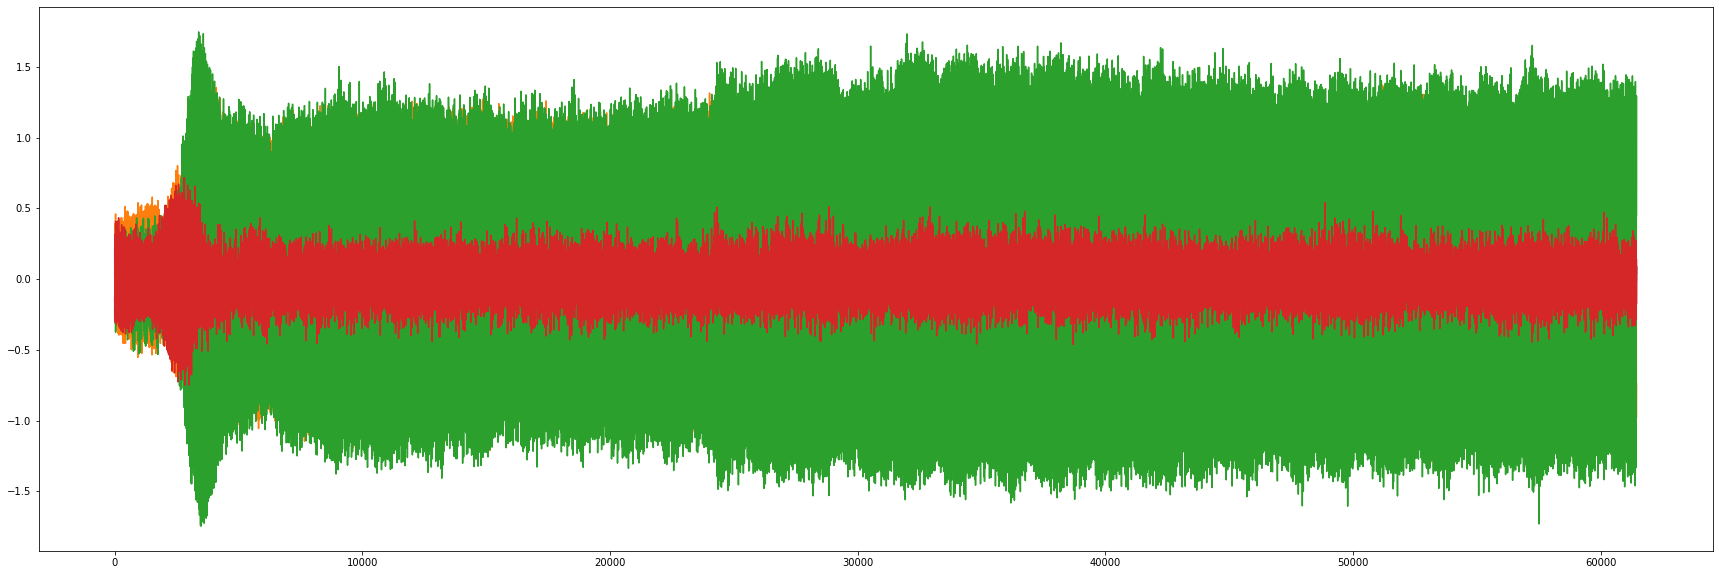

In [0]:
plt.figure(figsize=(30,10))
for i in range(4):
    plt.plot(range(61440),df.iloc[i,:61440])
plt.show()

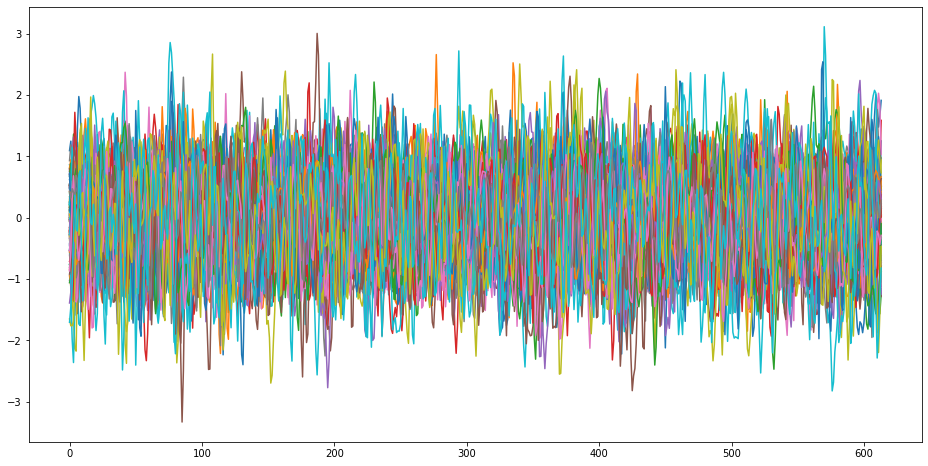

In [0]:
# Plot first 614 time points for first 100 observations
plt.figure(figsize=(16,8))
for i in range(100):
    plt.plot(range(614),xtrain[i,:614])
plt.show()

#### Random sample histogram observation

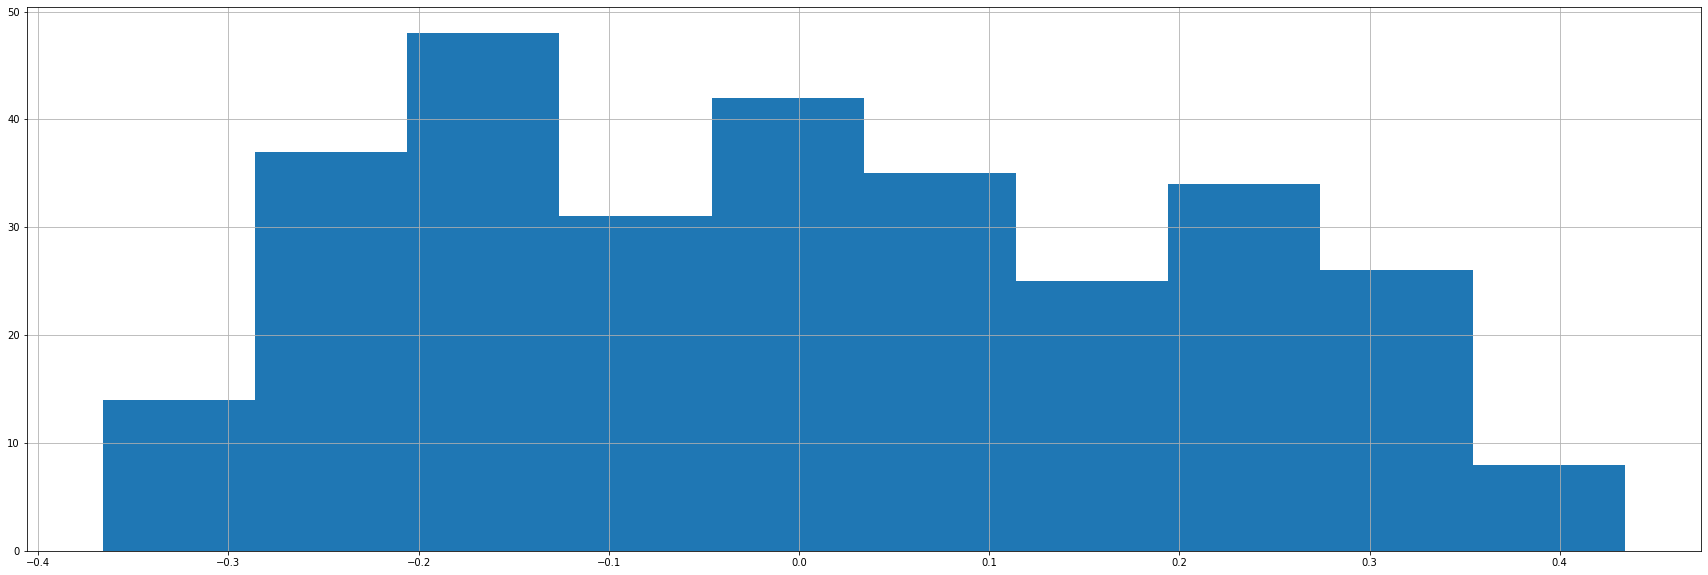

In [0]:
plt.figure(figsize=(30,10))
x1 = xtrain.iloc[3,:300]
x1.hist()
plt.show()

### Preprocessing

In [0]:
data = xtrain.iloc[:,:]
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)

In [0]:
test = xtest.iloc[:,:]
np_scaled = min_max_scaler.fit_transform(test)
test = pd.DataFrame(np_scaled)

## Statistical approach


> ### Autocorrelation


A Lag plot is a scatter plot of a time series against a lag of itself. If there is any pattern existing in the series, the series is autocorrelated. If there is no such pattern, the series is likely to be random white noise.

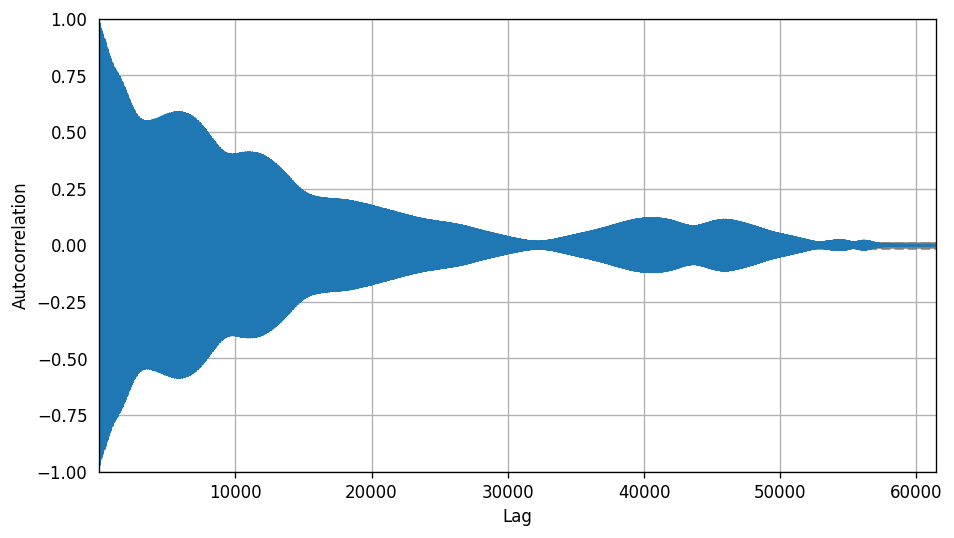

In [0]:
# Draw a sample plot to get a better insight of the signal
plt.rcParams.update({'figure.figsize':(9,5), 'figure.dpi':120})
autocorrelation_plot(xtrain.iloc[1,:])

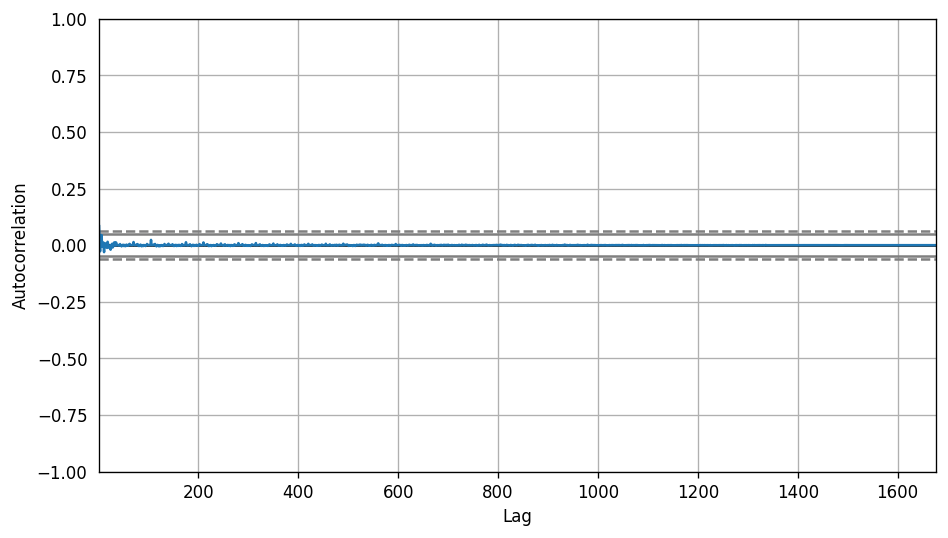

In [0]:
# Draw Plot
plt.rcParams.update({'figure.figsize':(9,5), 'figure.dpi':120})
autocorrelation_plot(xtrain.iloc[:,:])

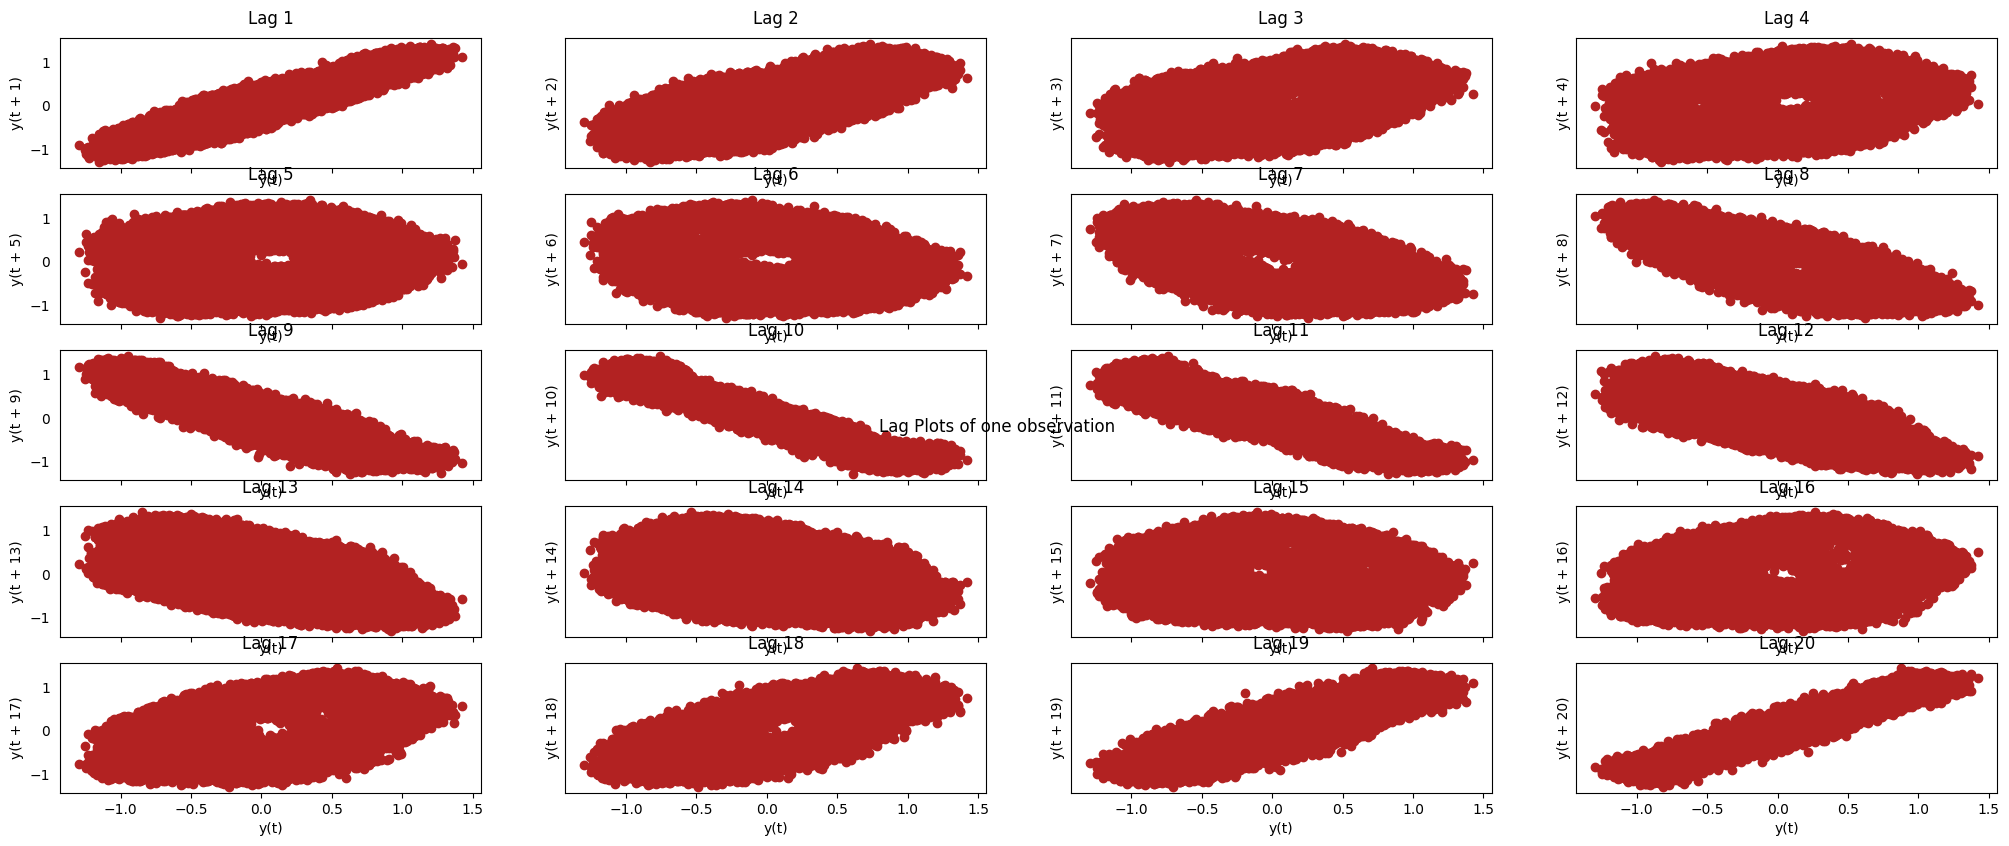

In [0]:
plt.rcParams.update({'ytick.left' : False, 'axes.titlepad':10})

# Plot
fig, axes = plt.subplots(5, 4, sharex=True, sharey=True, dpi=100)
for i, ax in enumerate(axes.flatten()[:20]):
    lag_plot(xtrain.iloc[1,:], lag=i+1, ax=ax, c='firebrick')
    ax.set_title('Lag ' + str(i+1))

fig.suptitle('Lag Plots of one observation', y=0.5)    
plt.show()


> ### Additive Decomposition: Trend / Seasonality / Stationarity



Any time series may be split into the following components: Base Level + Trend + Seasonality + Error

A trend is observed when there is an increasing or decreasing slope observed in the time series. Whereas seasonality is observed when there is a distinct repeated pattern observed between regular intervals due to seasonal factors.

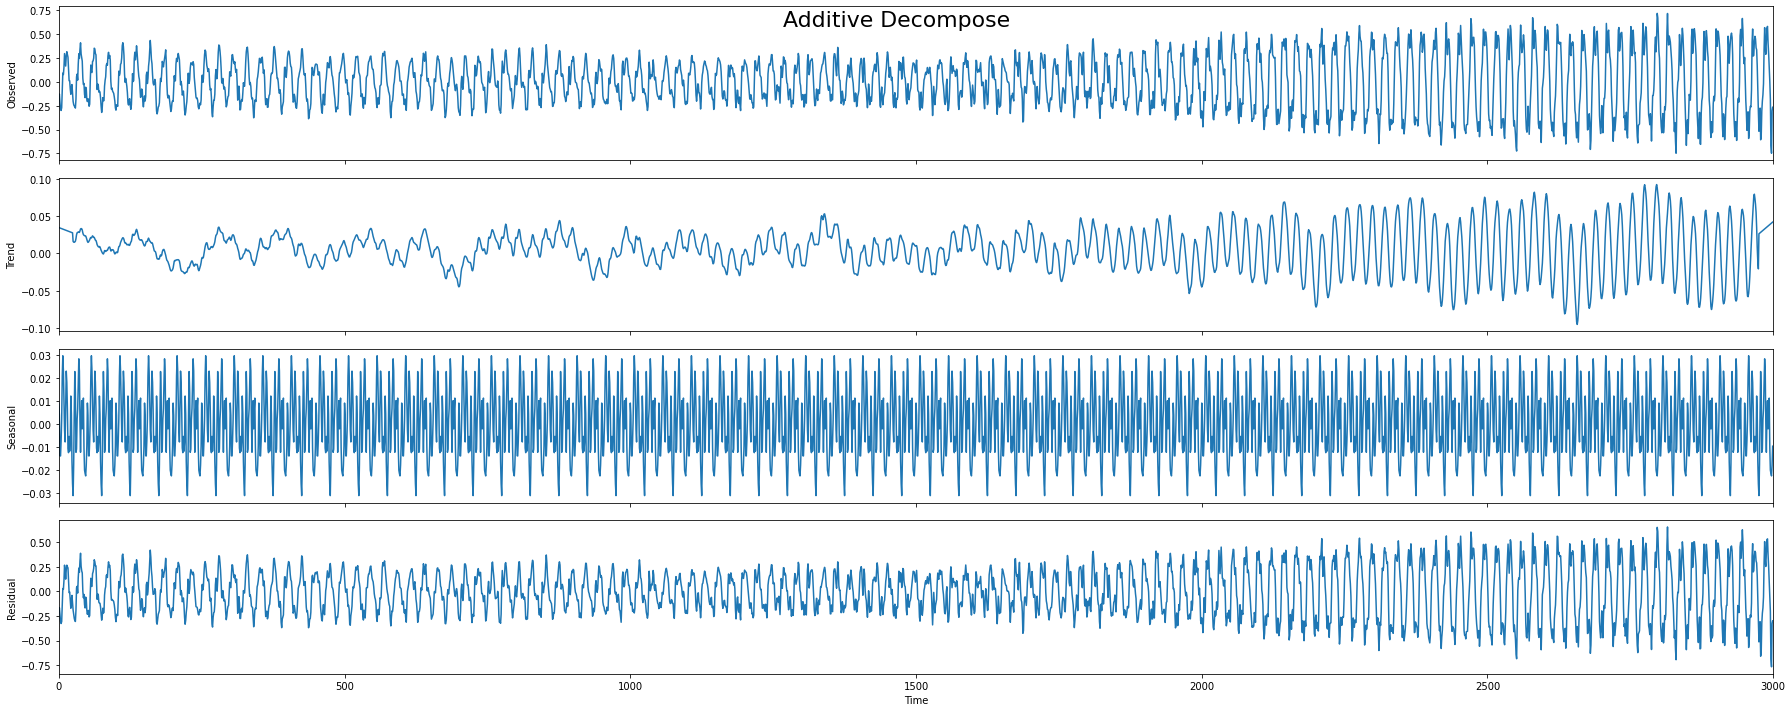

In [0]:
# Additive Decomposition
result_add = seasonal_decompose(xtrain.iloc[3,:3000].values, model='additive', freq=50, extrapolate_trend='freq')

# Multiplicative Decomposition : ValueError: Multiplicative seasonality is not appropriate for zero and negative values

# Plot
plt.rcParams.update({'figure.figsize': (25,10)})
result_add.plot().suptitle('Additive Decompose', fontsize=22)
plt.show()

In [0]:
# Extract the Components
# Additive time series: Value = Base Level + Trend + Seasonality + Error
df_reconstructed = pd.concat([pd.DataFrame(result_add.seasonal), pd.DataFrame(result_add.trend), pd.DataFrame(result_add.resid), pd.DataFrame(result_add.observed)], axis=1)
df_reconstructed.columns = ['seasonal', 'trend', 'resid', 'actual_values']
df_reconstructed.head()

,seasonal,trend,resid,actual_values
0,0.009112,0.034707,-0.198657,-0.154837
1,0.003829,0.034414,-0.166010,-0.127768
2,-0.013757,0.034120,-0.238002,-0.217638
3,-0.013871,0.033827,-0.304726,-0.284770
4,-0.007352,0.033533,-0.326110,-0.299929


We can use a statistical Unit Root Test to check if a time series is non-stationary and possess a unit root.

We consider the null hypothesis H0 as: the time series possesses a unit root and is non-stationary. So, if the P-Value in ADH test is less than the significance level (0.05), we reject HO.

In [0]:
# ADF Test
result = adfuller(xtrain.iloc[1,:].values, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'  {key}, {value}')

ADF Statistic: -24.99749125945634
p-value: 0.0
Critial Values:
  1%, -3.430456544151945
Critial Values:
  5%, -2.8615870905194267
Critial Values:
  10%, -2.5667950646925632


We then test the trend stationarity with the KPSS test. The H0 and the P-Value interpretation are just the opposite of ADH test.

In [0]:
# KPSS Test
result = kpss(xtrain.iloc[3,:].values, regression='c')
print('\nKPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[3].items():
    print('Critial Values:')
    print(f'   {key}, {value}')


KPSS Statistic: 0.004614
p-value: 0.100000
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:1685: FutureWarning: The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'
  warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:1711: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


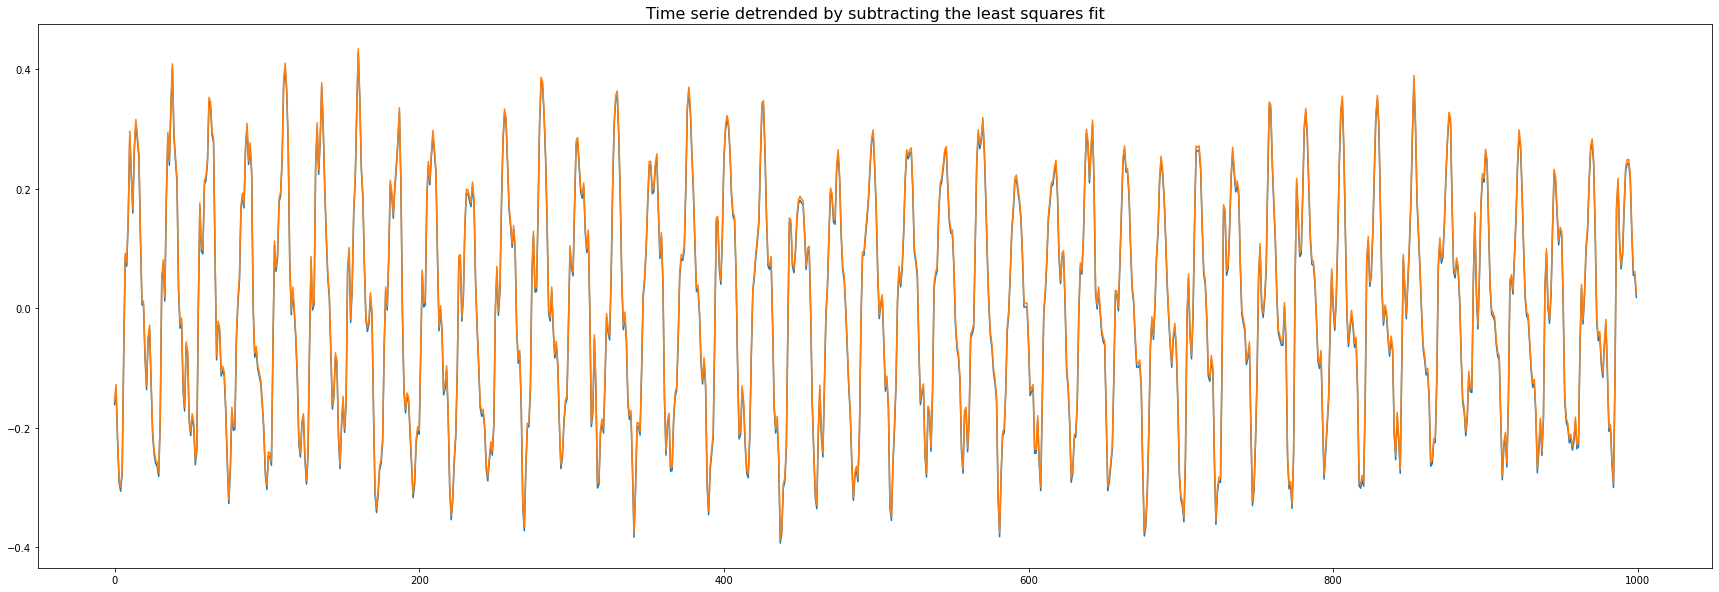

In [0]:
plt.figure(figsize=(30,10))
detrended = signal.detrend(xtrain.iloc[3,:1000].values)
plt.plot(detrended)
plt.title('Time serie detrended by subtracting the least squares fit', fontsize=16)
plt.plot(xtrain.iloc[3,:1000].values)
plt.show()

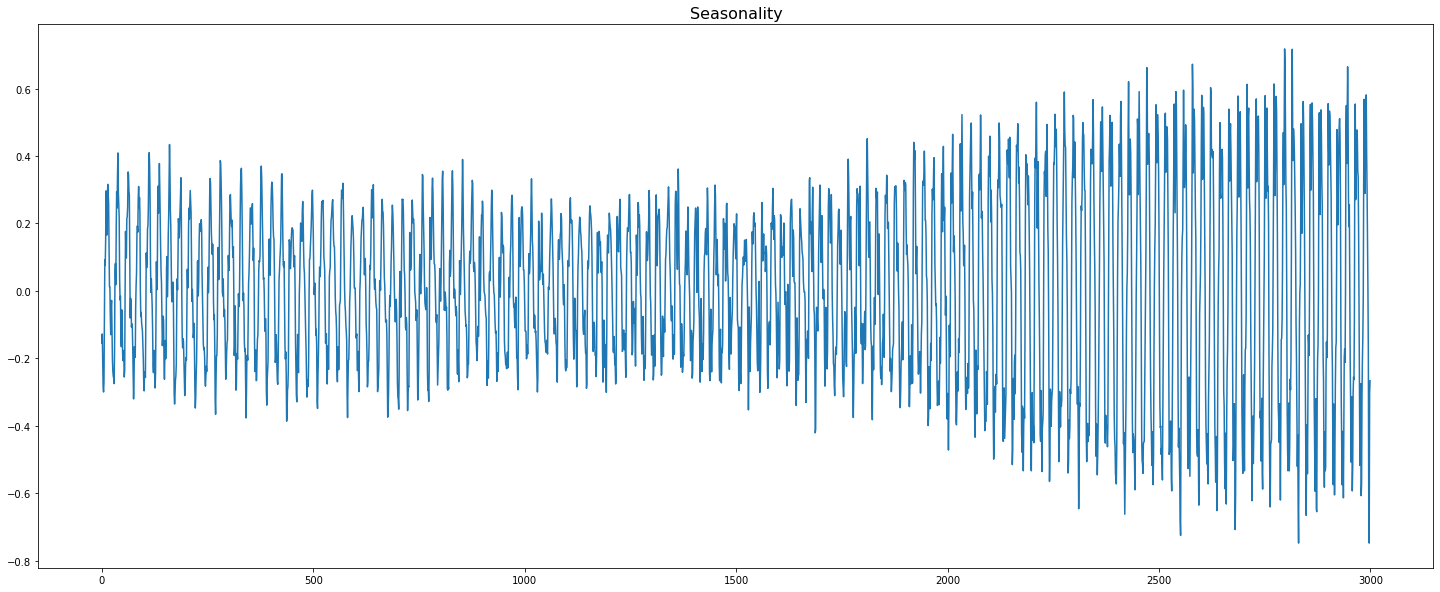

Text(0.5, 1.0, 'Serie deseasonalized')

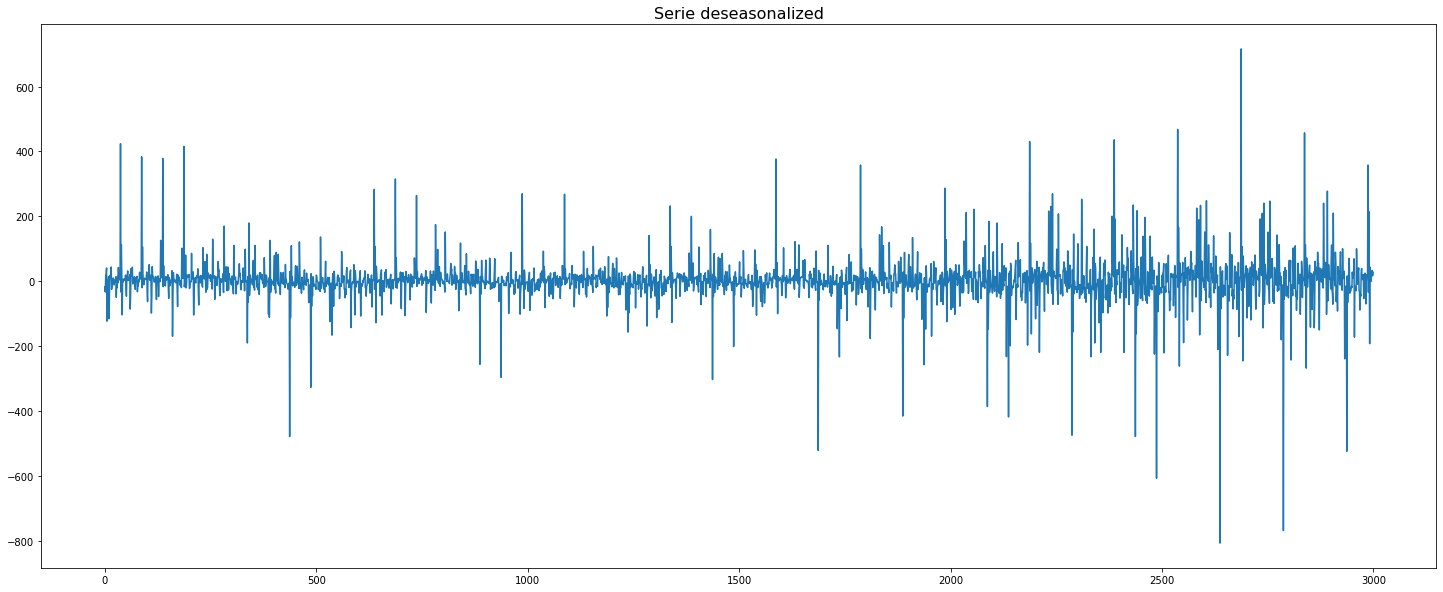

In [0]:
# Deseasonalize
deseasonalized = xtrain.iloc[3,:3000].values / result_add.seasonal

# Plot
plt.plot(xtrain.iloc[3,:3000].values)
plt.title('Seasonality', fontsize=16)
plt.show()
plt.plot(deseasonalized)
plt.title('Serie deseasonalized', fontsize=16)

/usr/local/lib/python3.6/dist-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


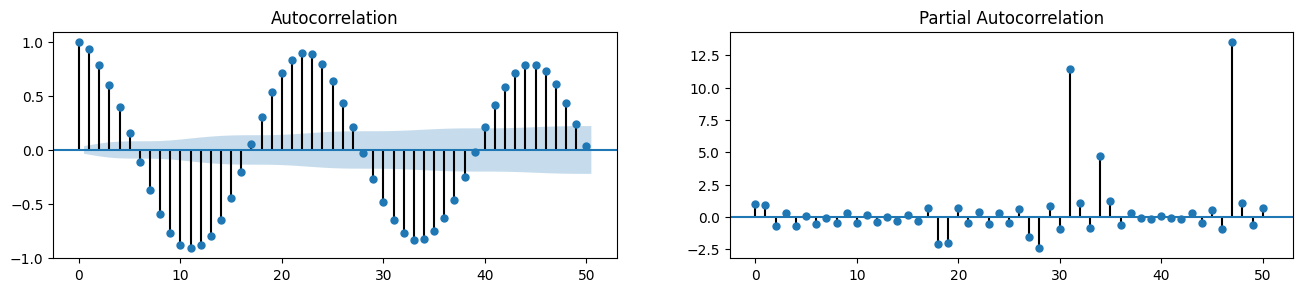

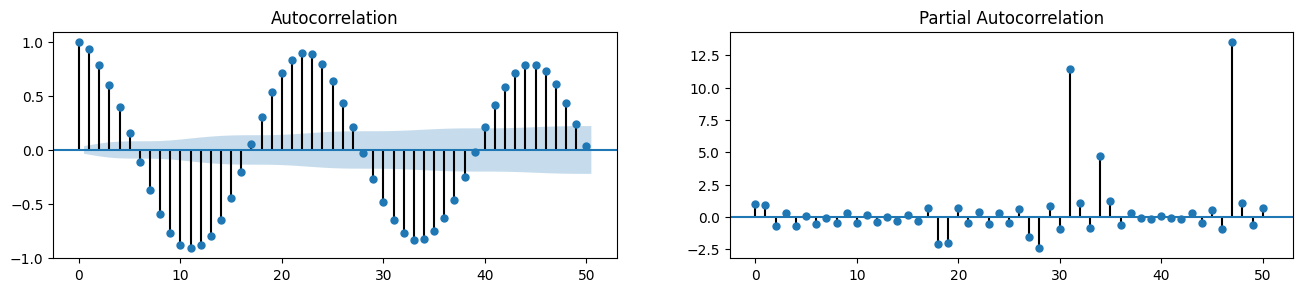

In [0]:
# Draw Plot
fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
plot_acf(xtrain.iloc[1,:3000], lags=50, ax=axes[0])
plot_pacf(xtrain.iloc[1,:3000], lags=50, ax=axes[1])

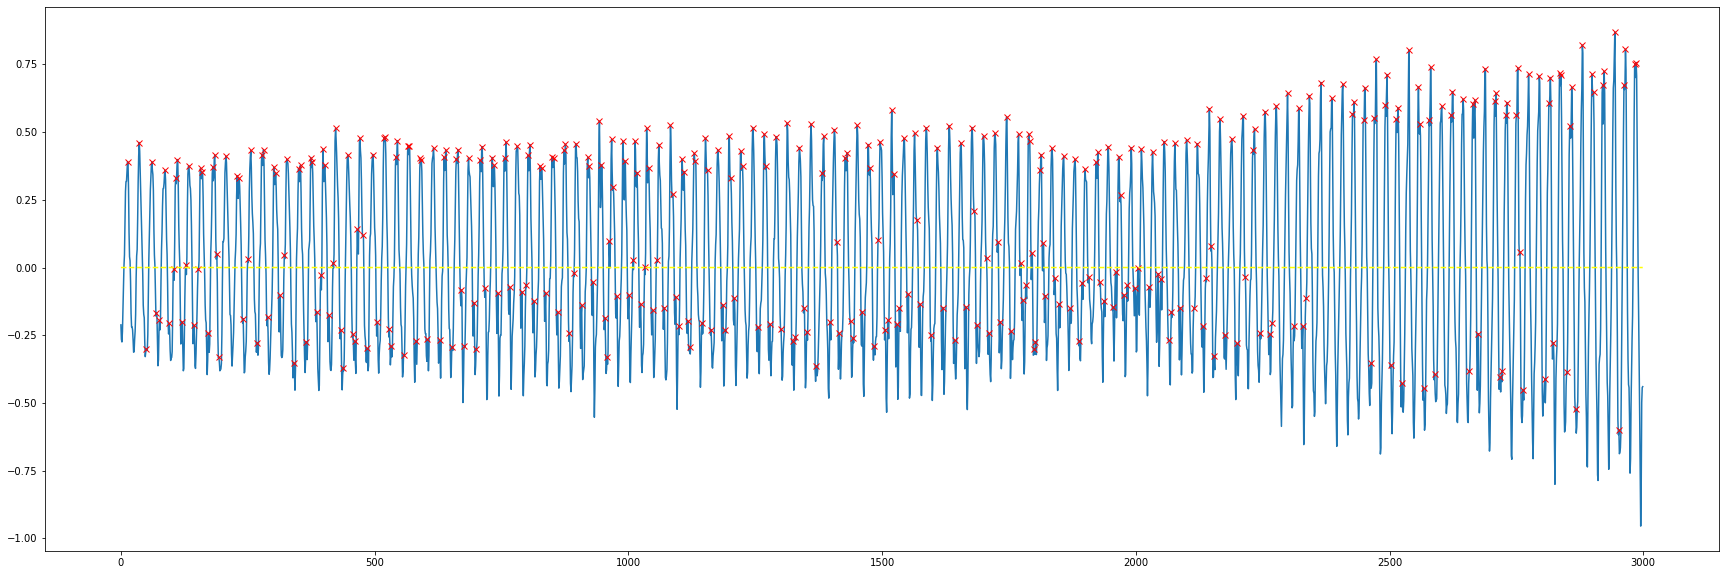

In [0]:
plt.figure(figsize=(30,10))
x = xtrain.iloc[1,:3000]
peaks, _ = find_peaks(x)
np.diff(peaks)
plt.plot(x)
plt.plot(peaks, x[peaks], "x", color="red" )
plt.plot(np.zeros_like(x), "--", color="yellow")
plt.show()

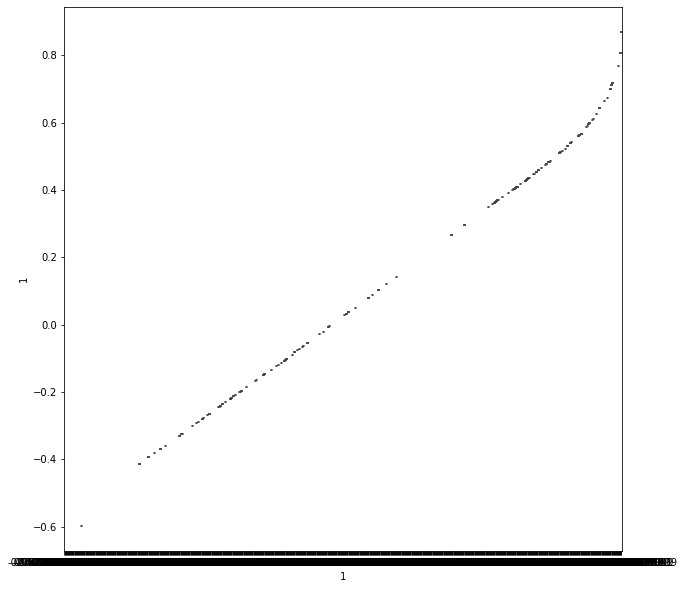

In [0]:
plt.figure(figsize=(10,10))
sns.boxplot(x=x, y=x[peaks], data=xtrain)

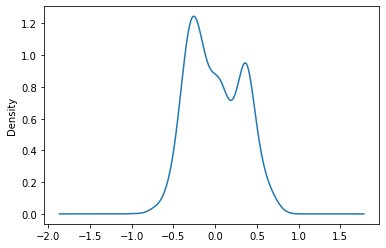

In [0]:
x.plot(kind='kde')
plt.show()

### Descriptive statistics


In [0]:
# percentile list 
perc =[.10, .30, .50, .75, 0.90] 
  
# list of dtypes to include 
include =['object', 'float', 'int'] 
  
# calling describe method 
desc = xtrain.describe(percentiles = perc, include = include) 
  
# display 
desc 

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,61400,61401,61402,61403,61404,61405,61406,61407,61408,61409,61410,61411,61412,61413,61414,61415,61416,61417,61418,61419,61420,61421,61422,61423,61424,61425,61426,61427,61428,61429,61430,61431,61432,61433,61434,61435,61436,61437,61438,61439
count,1677.000000,1677.000000,1677.000000,1677.000000,1677.000000,1677.000000,1677.000000,1677.000000,1677.000000,1677.000000,1677.000000,1677.000000,1677.000000,1677.000000,1677.000000,1677.000000,1677.000000,1677.000000,1677.000000,1677.000000,1677.000000,1677.000000,1677.000000,1677.000000,1677.000000,1677.000000,1677.000000,1677.000000,1677.000000,1677.000000,1677.000000,1677.000000,1677.000000,1677.000000,1677.000000,1677.000000,1677.000000,1677.000000,1677.000000,1677.000000,...,1677.000000,1677.000000,1677.000000,1677.000000,1677.000000,1677.000000,1677.000000,1677.000000,1677.000000,1677.000000,1677.000000,1677.000000,1677.000000,1677.000000,1677.000000,1677.000000,1677.000000,1677.000000,1677.000000,1677.000000,1677.000000,1677.000000,1677.000000,1677.000000,1677.000000,1677.000000,1677.000000,1677.000000,1677.000000,1677.000000,1677.000000,1677.000000,1677.000000,1677.000000,1677.000000,1677.000000,1677.000000,1677.000000,1677.000000,1677.000000
mean,-0.000664,-0.003480,0.009613,0.022475,0.035903,0.052162,0.070455,0.075893,0.056307,0.034468,0.031061,0.006954,-0.027298,-0.015888,0.009761,0.010156,0.018628,0.038524,0.022328,-0.007895,-0.015467,-0.011602,0.009214,0.041898,0.054470,0.044887,0.028042,0.010636,0.003315,-0.003389,-0.020587,-0.025043,-0.002662,0.015032,0.017562,0.017490,0.011162,0.003480,-0.001379,0.003469,...,0.006556,0.003262,0.007852,0.014262,0.014704,0.022838,0.031523,0.035599,0.050181,0.058342,0.045271,0.043864,0.043412,0.008992,-0.019945,-0.011217,-0.004932,-0.015490,-0.010381,0.009476,0.023566,0.019064,0.000714,0.004858,0.025804,0.020002,0.011052,0.032204,0.047951,0.036825,0.020256,0.015947,0.016758,-0.004421,-0.036975,-0.033517,-0.008975,0.008112,0.023029,0.021341
std,0.883526,0.835984,0.869802,0.950403,0.943731,0.820365,0.821559,0.912041,0.946185,0.869336,0.815796,0.869565,0.964937,0.920808,0.848196,0.831199,0.894075,0.920137,0.842245,0.814257,0.861901,0.922676,0.925577,0.875477,0.863034,0.918468,0.928509,0.889121,0.857181,0.848992,0.878428,0.920274,0.895541,0.844804,0.854706,0.912547,0.880881,0.858262,0.855928,0.885853,...,0.863248,0.843619,0.866635,0.887239,0.870043,0.817143,0.836787,0.867766,0.859182,0.823744,0.829628,0.879611,0.882915,0.853347,0.874222,0.891628,0.915202,0.918064,0.865608,0.815858,0.881484,0.935293,0.866778,0.867341,0.900711,0.961540,0.955066,0.859910,0.843732,0.905337,0.961493,0.899654,0.824489,0.887419,1.008669,0.948533,0.848945,0.828805,0.878701,0.937541
min,-7.496269,-6.943695,-8.947082,-8.999418,-8.675663,-6.466582,-7.234588,-8.339737,-8.434672,-7.559560,-5.686405,-7.952691,-10.075356,-10.065619,-6.672276,-7.133566,-7.852887,-9.450971,-6.371646,-7.918612,-10.296873,-9.543473,-8.948299,-7.782294,-6.476319,-8.702440,-11.618670,-9.129650,-6.336350,-8.539345,-10.461184,-9.407155,-9.386464,-6.705138,-6.482405,-8.564905,-6.460496,-7.695878,-8.659840,-7.196857,...,-7.838281,-6.894478,-4.732180,-7.641107,-8.724348,-6.291316,-8.704874,-8.129174,-6.535958,-6.381383,-5.295708,-7.706832,-10.497698,-10.808065,-5.822723,-9.814891,-10.430756,-10.152035,-8.118220,-4.735207,-5.732656,-8.626978,-7.171297,-6.843891,-9.743081,-10.335821,-6.551781,-7.614330,-6.393555,-6.964386,-11.528603,-11.482352,-5.818084,-8.860666,-11.643012,-9.185638,-6.622374,-5.228544,-5.582950,-7.378208
10%,-0.854171,-0.798109,-0.838089,-0.798253,-0.705572,-0.731107,-0.690322,-0.662993,-0.756155,-0.731207,-0.818221,-0.822687,-0.838520,-0.814070,-0.795206,-0.763061,-0.768044,-0.828264,-0.795392,-0.838129,-0.783537,-0.793156,-0.804809,-0.723310,-0.747904,-0.729629,-0.797627,-0.823394,-0.789441,-0.795978,-0.791948,-0.825790,-0.810951,-0.810486,-0.812199,-0.813310,-0.850133,-0

# II) Models
We start with basic classical algorithms used for anomaly detection.
## Classic models for Anomaly Detection
### PCA transform + Local Outlier Factor

In [0]:
pca1 = PCA(n_components = 10, whiten = True)
pca1.fit(data)
data_fit = pca1.fit_transform(data)

# standardize these 2 new features
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data_fit)
data = pd.DataFrame(np_scaled)

# Fit the low-dimensional method
lof1 = LocalOutlierFactor(n_neighbors = 5 ,contamination = 'auto', novelty = True)
lof1.fit(data)
# Calculate anomaly score on the (PCA-transformed) test data
xtest_fpca = pca1.fit_transform(xtest)
sscore = -lof1.score_samples(xtest_fpca)
print(sscore[:])### Projection on a low-dimensional space

[1.82178767 4.71808723 3.63958619 ... 2.84277098 2.70699445 1.68230471]


If we apply a min-max scaler to the whole data before the PCA and the LOF, we obtain a score of **0.440987800808**. 

If we try with only the 500 first observations of the train set, we obtain a score of **0.33**.

If we try with only the first 100 observations of the train set (as in the example submission file), we obtain a score of **0.723097198017**.


* **These scores show that the need to reduce the train set dimensions.**

### PCA + Isolation forest

In [0]:
outliers_fraction = 0.01
# train isolation forest 
model_if =  IsolationForest(contamination = outliers_fraction)
model_if.fit(data)
# add the data to the main  
data['anomaly2'] = pd.Series(model_if.predict(data))
data['anomaly2'] = data['anomaly2'].map( {1: 0, -1: 1} )
print(data['anomaly2'].value_counts())

0    1660
1      17
Name: anomaly2, dtype: int64


In [0]:
# Calculate anomaly score on the (Isolation-Forest-transformed) test data
xtest_if = model_if.fit(xtest)

In [0]:
sscore2 = -model_if.score_samples(xtest)
print(sscore2[:])

[0.30605476 0.30229646 0.37066895 ... 0.30793658 0.30281888 0.33404759]


Let's try to work on contamination and parameters of the Isolation forest with scaling our data before

In [0]:
data = xtrain.iloc[:,:]
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)

In [0]:
clf = IsolationForest(n_estimators=1000, contamination=0.05 )
clf.fit(data)

In [0]:
isolation_forest = 'models/isolationForest.sav'
loaded_if = pickle.load(open(isolation_forest, 'rb'))

In [0]:
score_isf = -clf.score_samples(xtest)
print(score_isf[:])

[0.32148418 0.31859255 0.46922656 ... 0.32441399 0.31877108 0.39727984]


With isolation forest alone, after we scale the data, we obtained a score of **0.30**.
If we vary the contamination and n_estimators, we can reach 0.33.

#### Performance criteria of the Isolation Forest
This part is based on the paper "How to Evaluate the Quality of Unsupervised Anomaly Detection Algorithms?" by Nicolas Goix

In [0]:
# Create scoring function generator
def gen(X):
    clf = IsolationForest(behaviour="new")
    clf.fit(X)
    return clf.score_samples

# Run AUMVC_hd
area = aumvc_hd(scoring_function_generator = gen,
                        X_train = data,
                        X_test = xtest,
                        N_selected_dim = 10,
                        N_iterations = 5,
                        N_mc = 3,
                        N_levelsets = 2,
                        normalise = True)

print("AUMVC_hd area: {}".format(area))

### OneClass SVM

In [0]:
# train one class SVM 
outliers_fraction = 0.01
ocs =  OneClassSVM(nu=0.95 * outliers_fraction)
ocs.fit(data)

OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma='scale', kernel='rbf',
            max_iter=-1, nu=0.0095, shrinking=True, tol=0.001, verbose=False)

In [0]:
# add the data to the main  
data['anomaly3'] = pd.Series(ocs.predict(data))
data['anomaly3'] = data['anomaly3'].map( {1: 0, -1: 1} )
print(data['anomaly3'].value_counts())

0    1584
1      93
Name: anomaly3, dtype: int64


In [0]:
ocs_model = 'models/ocsvm.sav'
pickle.dump(clf, open(ocs_model, 'wb'))

In [0]:
ocs= pickle.load(open(ocs_model, 'rb'))

In [0]:
# Calculate anomaly score on the (One-Class-SVM) test data
xtest_ocs = ocs.fit(xtest)  
sscore3 = ocs.score_samples(xtest)
print(sscore3[:])

[0.9334494  0.92651508 0.84452354 ... 0.92950613 0.928965   0.87732048]


#### Performance criteria of the One Class SVM

In [0]:
# Run AUMVC
area, alphas, volumes = metrics1.aumvc(scoring_function = ocs.score_samples,
                                      X_test = xtest,
                                      N_mc = 60000,
                                      N_levelsets = 5,
                                      normalise = True)

# Plot mass-volume curve
plt.plot(alphas, volumes)
plt.xlabel("Mass")
plt.ylabel("Volume")
plt.show()

### Models Perormance Summary:

---



| Algorithm  | **Score** |
| --- | --- |
| PCA on the whole train set + Local Outlier Factor | **0.440987** |
| PCA on 500 train set + Local Outlier Factor | 0.33 |
| **PCA on 100 obs** + **Local Outlier Factor** | **0.723097** |
| Isolation Forest |0.33 |
| **Isolation Forest with tuning hyperparameters** |0.39 |
| One Class SVM | 0.3 |





## Dimensionality reduction
### Principal Component Analysis (PCA)

In [0]:
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(desc)
desc = pd.DataFrame(np_scaled)

In [0]:
# PCA transform
pca1 = PCA(n_components = 10, whiten = True)
pca1.fit(desc.iloc[:,:])
xtrain_fpca = pca1.fit_transform(desc.iloc[:,:])
# Fit the low-dimensional method
lof1 = LocalOutlierFactor(n_neighbors = 5 ,contamination = 'auto', novelty = True)
lof1.fit(xtrain_fpca)
# Calculate anomaly score on the (PCA-transformed) test data
xtest_fpca = pca1.fit_transform(xtest)
desc_scaled = -lof1.score_samples(xtest_fpca)
print(desc_scaled[:100])

[1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.48219288 1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.03484977 1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.49881323 1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.        ]




> * **We obtain a score of 0.60635359116 which is really not that bad.**



### Extract features (Tsfresh)
The idea is to extract a comprehensive set of relevant periods of the signals. It is a way to compress more or less our signals. We will use the tsfresh package and call the tsfresh.extract_features() method. The idea is to filter the signals and obtain a new features matrix that can we train instead of our initial large train set.

In [0]:
xtrain1 = xtrain.copy()

In [0]:
xtrain1['index'] = xtrain1.index.values

In [0]:
settings = ComprehensiveFCParameters()
# Set here the options of the settings object as shown in the paragraphs below
X_extracted = extract_features(xtrain1, column_id='index', default_fc_parameters=settings)

> Unfortunately this method needs a lot of RAM, and google colab session wasn't sufficient to do so. Following several attempts to run the crashed session and reconnect google colab, I decided to abandon the idea of using tsfresh extract features method and move forward with other ideas to compress the signals.



### Discrete Wavelet Transform (DWT)
Wavelet transform is a very popular method when it comes to analysis, de-noising and compression of signals and images. In this section we want to perform a one dimensional Discrete Wavelet Transform in order to compress the signals and train with a "smaller" dataset.

In [0]:
w = pywt.Wavelet('sym5')
pywt.dwt_max_level(data_len=len(xtrain1), filter_len=w.dec_len)
pywt.dwt_max_level(6000,'sym5')

9

In [0]:
(cA, cD) = pywt.dwt(xtrain1, 'db1')
#The transform coefficients are returned as two arrays containing approximation (cA) and detail (cD) coefficients respectively
cA = pd.DataFrame(cA)
cD = pd.DataFrame(cD)
cA.shape, cD.shape

((1677, 30721), (1677, 30721))

In [0]:
# PCA transform
pca1 = PCA(n_components = 10, whiten = True)
pca1.fit(cA.iloc[:,:])
xtrain_fpca = pca1.fit_transform(cA.iloc[:,:])
# Fit the low-dimensional method
lof1 = LocalOutlierFactor(n_neighbors = 5 ,contamination = 'auto', novelty = True)
lof1.fit(xtrain_fpca)
# Calculate anomaly score on the (PCA-transformed) test data
xtest_fpca = pca1.fit_transform(xtest)
score_cA = -lof1.score_samples(xtest_fpca)
print(score_cA[:100])

[ 4.29946754  2.15433475  5.63407087  2.67943743  2.52575068  2.53882003
  1.73706825  5.01988878  2.3922583   2.22938319  3.97717652  2.42589893
  2.58248106  1.76302384  2.61691713  2.0609173   2.17920207  2.37763834
  1.75481174  2.72991543  1.8124213   2.35304621  2.47510602  3.46933131
  2.09733738  2.33087528  2.45632347  2.43928926  3.64089427  2.8151391
  5.11840644  2.43716224  3.41937667  2.31815052  5.33834957  1.06629121
  3.83899709  1.41823554  2.09972482  6.76575091  4.48468801  2.47589985
  2.28197229  2.35409423  2.44484354  1.54581165  1.2012319   1.60445644
 10.13075702  4.17650975  4.69829202  3.12913988  2.42981694  6.18845781
  6.77222467  2.31145582  2.64430786  2.72154387  2.32503391  2.55407092
  2.31142892  3.47366216  3.58889938  2.3992159   2.34867766  2.36377901
  5.05882541  2.75966255  4.02089328  2.47631066  2.38761576  2.08726237
  9.0038865   2.79026066  3.17854002  1.32333927  2.04571068  2.75254105
  4.83576007  2.76446168  2.76360913  1.53472294  2.

In [0]:
print(score_cA.shape)
np.savetxt(path+'scores/DWT_score_cA.csv', score_cA, fmt = '%1.6f', delimiter=',')

(2511,)


In [0]:
# PCA transform
pca1 = PCA(n_components = 10, whiten = True)
pca1.fit(cD.iloc[:,:])
xtrain_fpca = pca1.fit_transform(cD.iloc[:,:])
# Fit the low-dimensional method
lof1 = LocalOutlierFactor(n_neighbors = 5 ,contamination = 'auto', novelty = True)
lof1.fit(xtrain_fpca)
# Calculate anomaly score on the (PCA-transformed) test data
xtest_fpca = pca1.fit_transform(xtest)
score_cD = -lof1.score_samples(xtest_fpca)
print(score_cD[:100])

[1.87236454 2.64300769 1.84273769 2.57502442 2.67362166 2.61156334
 1.95540358 2.48523142 2.34593987 2.23487979 2.35089048 2.46944676
 2.33657816 2.35248334 2.30886642 2.74746151 2.81135182 2.84888873
 2.5239697  2.35206657 2.83708463 2.99755632 2.47516457 1.88848689
 3.25696128 2.44679577 2.46374208 2.27664675 2.37416739 2.27055345
 3.62204417 2.32082839 2.99182885 2.39668617 3.00063445 2.62801298
 1.91252718 3.23702041 2.81767164 2.95455306 2.49476303 2.75474269
 2.62736639 2.84318438 2.22232606 2.63674266 2.08765879 3.01152872
 1.45764779 2.3137605  3.15368402 2.22620369 2.7568607  1.87563828
 1.83108809 2.59158875 2.58082581 2.25542993 2.89836666 2.64341991
 2.08377222 3.02474563 1.94418918 2.38450463 1.95834639 2.68531598
 2.55481157 2.63253978 2.03463351 2.82563612 4.59443542 2.22591368
 3.64320321 2.60379578 2.24281446 1.73831022 2.49337607 2.60231643
 2.52621842 2.40563612 2.71325732 2.80985034 2.22201551 2.43076765
 2.49889689 3.04461566 2.77343116 2.89745234 2.44953032 2.0835

In [0]:
coeffs = wavedec(xtrain1, 'db1', level=2)
cA2, cD2, cD1 = coeffs
cA2 = pd.DataFrame(cA2)
cD2 = pd.DataFrame(cD2)
cA2.shape, cD2.shape, cD1.shape

((1677, 15361), (1677, 15361), (1677, 30721))

In [0]:
# PCA transform
pca1 = PCA(n_components = 10, whiten = True)
pca1.fit(cA2.iloc[:,:])
xtrain_fpca = pca1.fit_transform(cA2.iloc[:,:])
# Fit the low-dimensional method
lof1 = LocalOutlierFactor(n_neighbors = 5 ,contamination = 'auto', novelty = True)
lof1.fit(xtrain_fpca)
# Calculate anomaly score on the (PCA-transformed) test data
xtest_fpca = pca1.fit_transform(xtest)
score_cA2 = -lof1.score_samples(xtest_fpca)
print(score_cA2[:100])

[ 3.15478272  2.87748095  4.58167335  3.4530672   2.57739136  2.61821175
  2.71611374  3.40340202  2.76937584  3.14157228  2.0463431   2.64889623
  2.64246154  3.00309992  2.65624259  2.44596204  2.77225523  2.48948925
  3.21246027  2.5490223   3.09437891  2.41595018  2.55858699  4.23987258
  2.38194045  2.4960677   2.53932341  2.65533977  3.88793321  2.78783154
  4.22646674  2.24664697  2.85261885  2.22884739  4.47626542  2.94054074
  2.96764003  3.02255757  3.30336511  3.40243022  3.004433    2.29816634
  2.555974    2.49456878  2.52159121  2.55613582  5.94307669  2.44848413
  7.58272951  5.4137117   3.15245498  3.3766699   2.55191864  4.06461968
  2.37319517  2.48173862  2.47355809  1.36963048  2.43995044  2.40232731
  2.94411515  2.44892697  2.97442572  2.54811523  2.91180217  2.46130228
  2.74683928  2.60643884  3.10430424  3.52455774  3.21763236  2.66017937
  6.8342846   2.99625417  4.37393855  3.57898354  2.52725453  2.80106958
  4.20263415  2.55705245  2.9234939   1.79477066  7

In [0]:
# PCA transform
pca1 = PCA(n_components = 10, whiten = True)
pca1.fit(cD2.iloc[:,:])
xtrain_fpca = pca1.fit_transform(cD2.iloc[:,:])
# Fit the low-dimensional method
lof1 = LocalOutlierFactor(n_neighbors = 5 ,contamination = 'auto', novelty = True)
lof1.fit(xtrain_fpca)
# Calculate anomaly score on the (PCA-transformed) test data
xtest_fpca = pca1.fit_transform(xtest)
score_cD2 = -lof1.score_samples(xtest_fpca)
print(score_cD2[:100])

[2.15197164 2.7442453  2.63302818 2.73316426 2.72220266 3.12494673
 2.14525354 2.13175653 2.64547104 1.38378103 2.24826891 2.41323801
 2.32768615 2.8301221  2.32943857 2.54643544 2.64196764 2.41363314
 2.42517394 2.59228016 2.44834857 2.5558728  2.54142772 2.43717689
 3.21328632 2.40967944 2.43265069 2.45316081 2.06468681 2.49739898
 3.00236505 2.30367345 3.40014842 2.43592026 2.61148784 2.80822239
 2.58616783 2.72565369 3.35771421 3.75364654 2.8241128  2.48075176
 3.01884574 2.41220795 2.40490874 2.31241509 2.74795734 2.75260642
 2.6357607  2.3672019  3.38225487 2.12870609 2.35742708 1.60617211
 1.78076481 2.53358958 2.41339746 1.96211077 2.45708272 2.58303926
 1.80456025 2.49477914 3.10679321 2.3292131  2.47836772 2.61228535
 2.27215313 2.62723177 2.49340296 3.12086827 3.60561754 2.15618916
 2.20362589 2.33989151 2.13628969 2.6618374  2.29883248 2.9499785
 2.39583063 2.59030935 2.48595408 2.59630864 2.82157684 2.38900417
 2.23323513 2.91851344 2.36433193 2.4398648  2.40942646 2.03557

> * **We obtain a great score with cA** (**0,771) but it's not the best score. cA2 and cD2 give pretty good scores too.**

## LSTM Autoencoder
I applied LSTM which is best suited for time-seriers and sequential problems when we have a large dataset.
<br>
<br>
The autoencoder's role is to learn the most relevant features of the data. The reconstruction of the compressed signals should match the input as much as possible. 
We used a couple of LSTM layers (hence the LSTM Autoencoder) to capture the temporal dependencies of the data.

### Reconstruction Loss

When training an Autoencoder, the objective is to reconstruct the input as best as possible, by minimizing a *reconstruction loss* (Cross-entropy loss, MSE)

In [0]:
train = np.reshape(data.to_numpy(), (obs, 1, entries))
test = np.reshape(xtest.to_numpy(), (xtest.shape[0], 1, xtest.shape[1]))

In [0]:
model = Sequential()

model.add(LSTM(
    input_dim=xtrain.shape[-1],
    output_dim=50,
    return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(
    100,
    return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(
    units=1))
model.add(Activation('linear'))

start = time.time()
#model.compile(loss='mse', optimizer='rmsprop')
model.compile(loss='mean_squared_error', optimizer='adam')
print('compilation time : {}'.format(time.time() - start))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(return_sequences=True, input_shape=(None, 614..., units=50)`
  


compilation time : 0.01535177230834961


In [0]:
ytrain = np.ones(xtrain.shape[0], dtype=int)
ytrain = pd.DataFrame(ytrain)

In [0]:
# Fitting to the training set
model.fit(train, ytrain, batch_size=32, epochs=50)

Epoch 1/50
1677/1677 [==============================] - 2s 1ms/step - loss: 0.0096
Epoch 2/50
1677/1677 [==============================] - 2s 1ms/step - loss: 0.0078
Epoch 3/50
1677/1677 [==============================] - 2s 1ms/step - loss: 0.0062
Epoch 4/50
1677/1677 [==============================] - 2s 1ms/step - loss: 0.0056
Epoch 5/50
1677/1677 [==============================] - 2s 1ms/step - loss: 0.0059
Epoch 6/50
1677/1677 [==============================] - 2s 1ms/step - loss: 0.0046
Epoch 7/50
1677/1677 [==============================] - 2s 1ms/step - loss: 0.0047
Epoch 8/50
1677/1677 [==============================] - 2s 1ms/step - loss: 0.0044
Epoch 9/50
1677/1677 [==============================] - 2s 1ms/step - loss: 0.0038
Epoch 10/50
1677/1677 [==============================] - 2s 1ms/step - loss: 0.0043
Epoch 11/50
1677/1677 [==============================] - 2s 1ms/step - loss: 0.0040
Epoch 12/50
1677/1677 [==============================] - 2s 1ms/step - loss: 0.0037
E

In [0]:
score_lstm = model.predict(test)
print(score_lstm)

[[1.0112641]
 [0.9895805]
 [0.9889904]
 ...
 [1.0184107]
 [0.9129827]
 [0.989125 ]]


#### LSTM Autoencoders with PyTorch

We split the train set into train and validation and convert them into tensors to train the autoencoder.

In [0]:
normal_df = xtrain

In [0]:
train_df, val_df = train_test_split(
  normal_df,
  test_size=0.15,
  random_state=RANDOM_SEED
)

In [0]:
def create_dataset(df):
    sequences = df.astype(np.float32).to_numpy().tolist()
    dataset = [torch.tensor(s).unsqueeze(1).float() for s in sequences]
    n_seq, seq_len, n_features = torch.stack(dataset).shape
    return dataset, seq_len, n_features

In [0]:
train, seq_train_len, n_train_features = create_dataset(xtrain)
test, seq_test_len, n_test_features = create_dataset(xtest)

In [0]:
train_dataset, seq_len, n_features = create_dataset(train_df)
val_dataset, _, _ = create_dataset(val_df)

The general Autoencoder architecture consists of two components. An *Encoder* that compresses the input and a *Decoder* that tries to reconstruct it.

We used the LSTM Autoencoder from this [GitHub repo](https://github.com/shobrook/sequitur) with some small tweaks.

In [0]:
class Encoder(nn.Module):
    def __init__(self, seq_len, n_features, embedding_dim=64):
        super(Encoder, self).__init__()
        
        self.seq_len, self.n_features = seq_len, n_features
        self.embedding_dim, self.hidden_dim = embedding_dim, 2 * embedding_dim
        
        self.rnn1 = nn.LSTM(
            input_size=n_features,
            hidden_size=self.hidden_dim,
            num_layers=1,
            batch_first=True
        )
        
        self.rnn2 = nn.LSTM(
            input_size=self.hidden_dim,
            hidden_size=embedding_dim,
            num_layers=1,
            batch_first=True
        )

    def forward(self, x):
        x = x.reshape((1, self.seq_len, self.n_features))
        x, (_, _) = self.rnn1(x)
        x, (hidden_n, _) = self.rnn2(x)
        return hidden_n.reshape((self.n_features, self.embedding_dim))

The Encoder uses two LSTM layers to compress the Time Series data input.

Next, we'll decode the compressed representation using a *Decoder*:

In [0]:
class Decoder(nn.Module):
    def __init__(self, seq_len, input_dim=64, n_features=1):
        super(Decoder, self).__init__()
        self.seq_len, self.input_dim = seq_len, input_dim

        self.hidden_dim, self.n_features = 2 * input_dim, n_features
        self.rnn1 = nn.LSTM(
            input_size=input_dim,
            hidden_size=input_dim,
            num_layers=1,
            batch_first=True
            )
        
        self.rnn2 = nn.LSTM(
            input_size=input_dim,
            hidden_size=self.hidden_dim,
            num_layers=1,
            batch_first=True
            )
        
        self.output_layer = nn.Linear(self.hidden_dim, n_features)

    def forward(self, x):
        x = x.repeat(self.seq_len, self.n_features)
        x = x.reshape((self.n_features, self.seq_len, self.input_dim))
        
        x, (hidden_n, cell_n) = self.rnn1(x)
        x, (hidden_n, cell_n) = self.rnn2(x)
        x = x.reshape((self.seq_len, self.hidden_dim))
        
        return self.output_layer(x)

Our Decoder contains two LSTM layers and an output layer that gives the final reconstruction.

In [0]:
class RecurrentAutoencoder(nn.Module):
    def __init__(self, seq_len, n_features, embedding_dim=64):
        super(RecurrentAutoencoder, self).__init__()
        
        self.encoder = Encoder(seq_len, n_features, embedding_dim).to(device)
        self.decoder = Decoder(seq_len, embedding_dim, n_features).to(device)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)

        return x

Our Autoencoder passes the input through the Encoder and Decoder. Let's create an instance of it:


In [0]:
model = RecurrentAutoencoder(seq_len, n_features, 128)
model = model.to(device)

In [0]:
def train_model(model, train_dataset, val_dataset, n_epochs):
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.L1Loss(reduction='sum').to(device)
    history = dict(train=[], val=[])
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 10000.0
  
    for epoch in range(1, n_epochs + 1):
        model = model.train()
        
        train_losses = []
        
        for seq_true in train_dataset:
            optimizer.zero_grad()
            
            seq_true = seq_true.to(device)
            seq_pred = model(seq_true)
            
            loss = criterion(seq_pred, seq_true)
            
            loss.backward()
            optimizer.step()
            
            train_losses.append(loss.item())

        val_losses = []
        model = model.eval()
    
        with torch.no_grad():
            for seq_true in val_dataset:
                seq_true = seq_true.to(device)
                seq_pred = model(seq_true)
                
                loss = criterion(seq_pred, seq_true)
                val_losses.append(loss.item())

        train_loss = np.mean(train_losses)
        val_loss = np.mean(val_losses)

        history['train'].append(train_loss)
        history['val'].append(val_loss)

        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())

        print(f'Epoch {epoch}: train loss {train_loss} val loss {val_loss}')

    model.load_state_dict(best_model_wts)
    return model.eval(), history

At each epoch, the training process feeds our model with all training observations and evaluates the performance on the validation set. Note that we're using a batch size of 1 (our model sees only 1 sequence at a time). We also record the training and validation set losses during the process.

We want the model with the smallest validation error, so we minimize the L1Loss, which measures the MAE (mean absolute error).

In [0]:
model, history = train_model(
  model, 
  train_dataset, 
  val_dataset, 
  n_epochs=5
)

Epoch 1: train loss 31794.009834155702 val loss 35405.92037963867
Epoch 2: train loss 31797.623875925165 val loss 35311.70788283575
Epoch 3: train loss 31694.307708333334 val loss 35280.99067470006
Epoch 4: train loss 31665.99150287829 val loss 35394.677116757346
Epoch 5: train loss 31701.95761316132 val loss 35247.557451520646


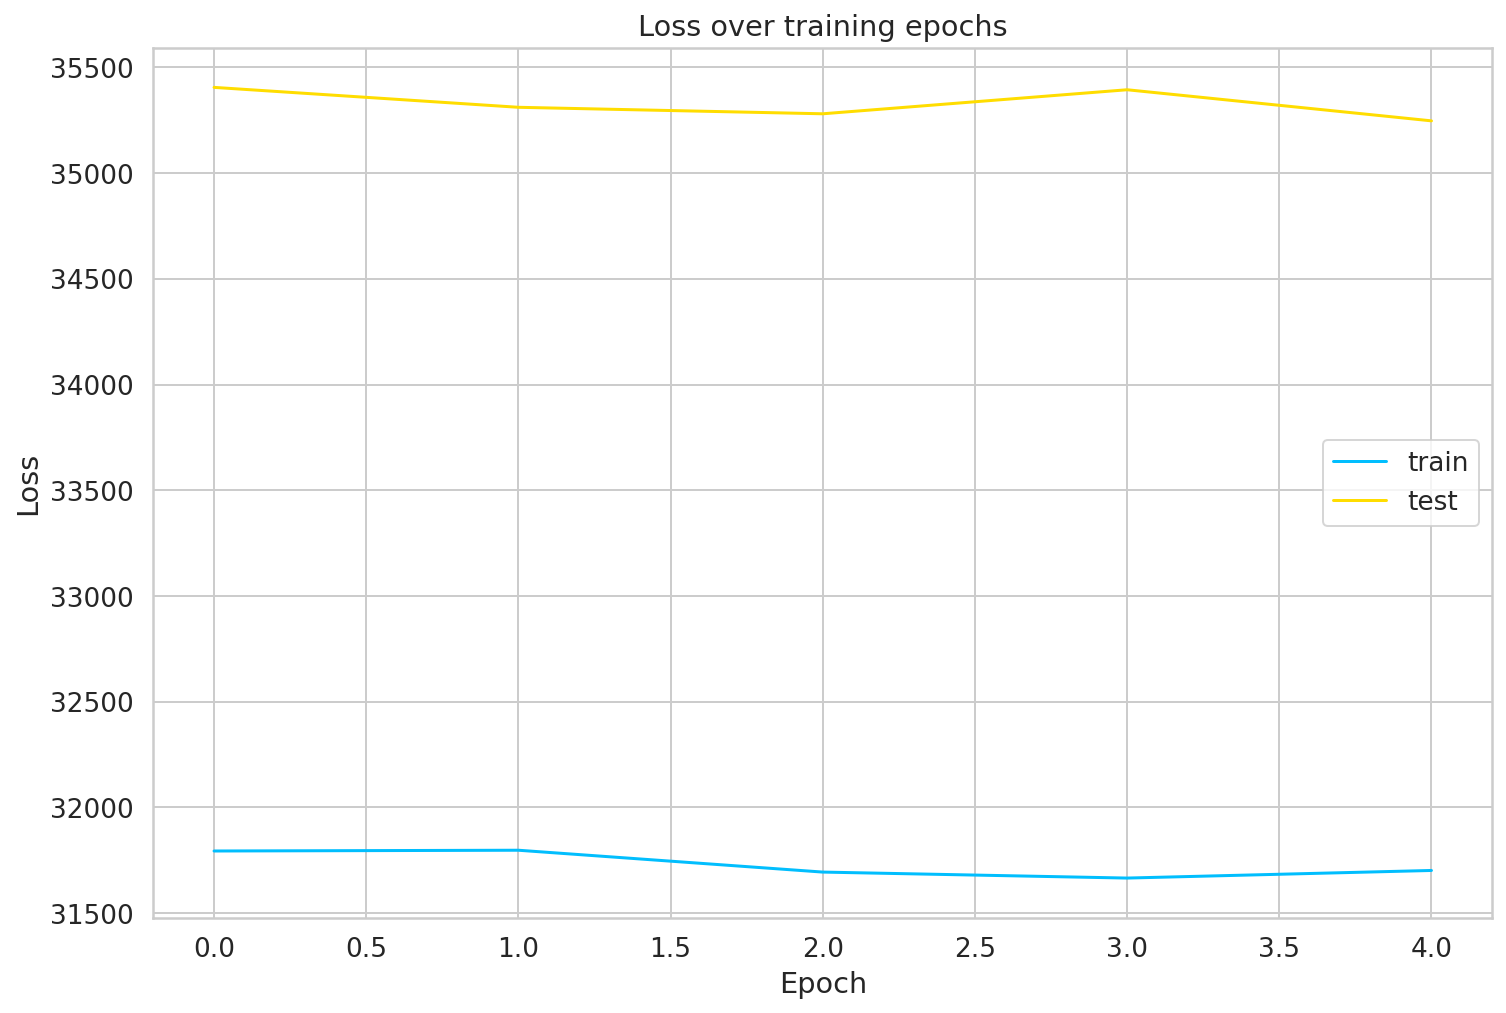

In [0]:
ax = plt.figure().gca()

ax.plot(history['train'])
ax.plot(history['val'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Loss over training epochs')
plt.show();

> * **Unfortunately up to 5 epochs, the session crushes so we weren't able to try more epochs and see if the losses converge.**


We save the model.

In [0]:
#MODEL_PATH = 'model.pth'
#path = '/content/drive/My Drive/BGD/MDI341/data challenge/'
#torch.save(model, path+MODEL_PATH)

We load our model:

In [0]:
model = torch.load('/content/drive/My Drive/BGD/MDI341/data challenge/models/model.pth')
model = model.to(device)

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:657: SourceChangeWarning: source code of class 'torch.nn.modules.rnn.LSTM' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:657: SourceChangeWarning: source code of class 'torch.nn.modules.linear.Linear' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


#### Choosing a threshold
The threshold is kind of a separation between the normal observations and the outliers.

In [0]:
def predict(model, dataset):
    predictions, losses = [], []
    criterion = nn.L1Loss(reduction='sum').to(device)
    
    with torch.no_grad():
        model = model.eval()
        
        for seq_true in dataset:
            seq_true = seq_true.to(device)
            seq_pred = model(seq_true)
            
            loss = criterion(seq_pred, seq_true)
            
            predictions.append(seq_pred.cpu().numpy().flatten())
            losses.append(loss.item())
    return predictions, losses

Our function goes through each example in the dataset and records the predictions and losses.

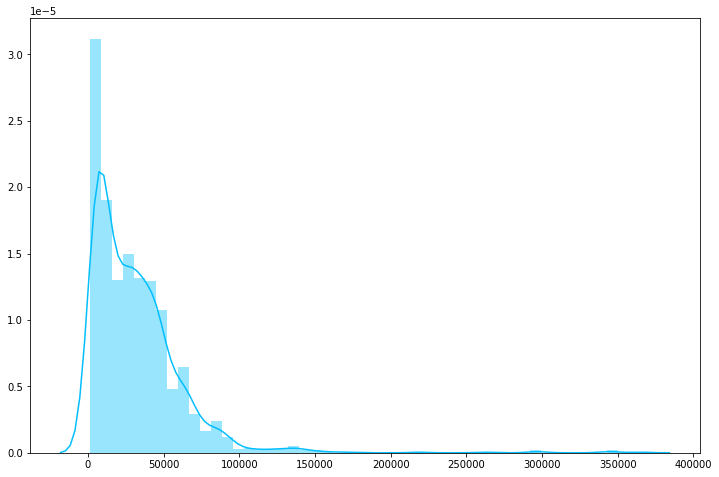

In [0]:
_, losses = predict(model, train_dataset)
sns.distplot(losses, bins=50, kde=True);

In [0]:
THRESHOLD = 120000

#### Evaluation

The problem then is a binary classification problem:

- If the reconstruction loss for an example is below the threshold, we'll classify it as a *normal* observation
- Otherwise it is an anomaly

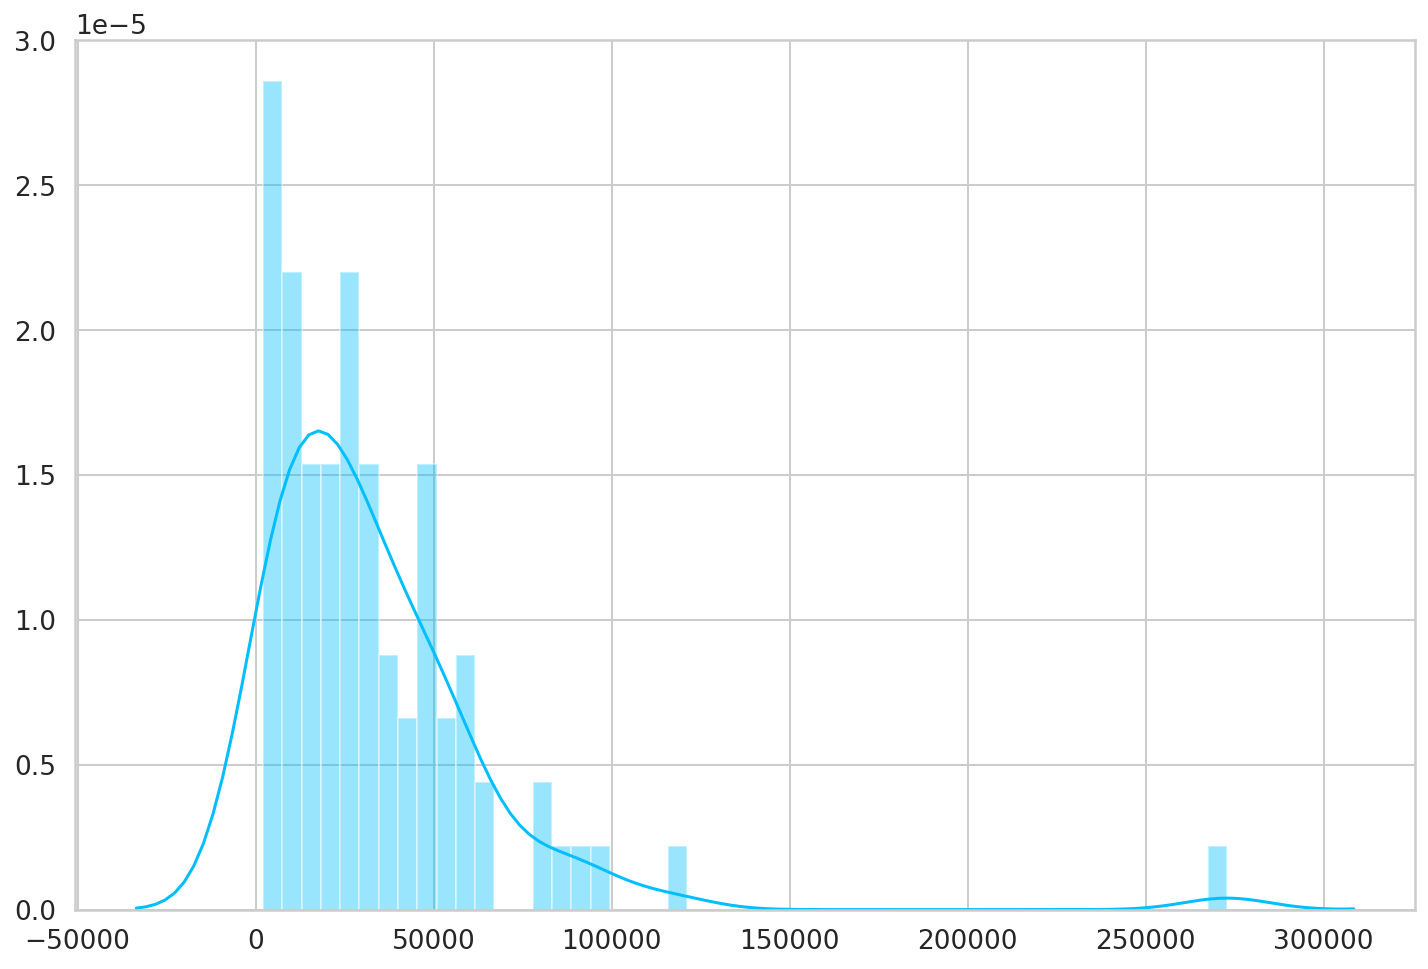

In [0]:
# Validation set 
predictions, pred_losses = predict(model, val_dataset)
sns.distplot(pred_losses, bins=50, kde=True);

In [0]:
correct = sum(l <= THRESHOLD for l in pred_losses)
print(f'Number of correct normal predictions on the validation set: {correct}/{len(val_dataset)}')

Correct normal predictions: 82/84


#### Prediction on the test set
Now we can take the predictions of our model for the subset of anomalies



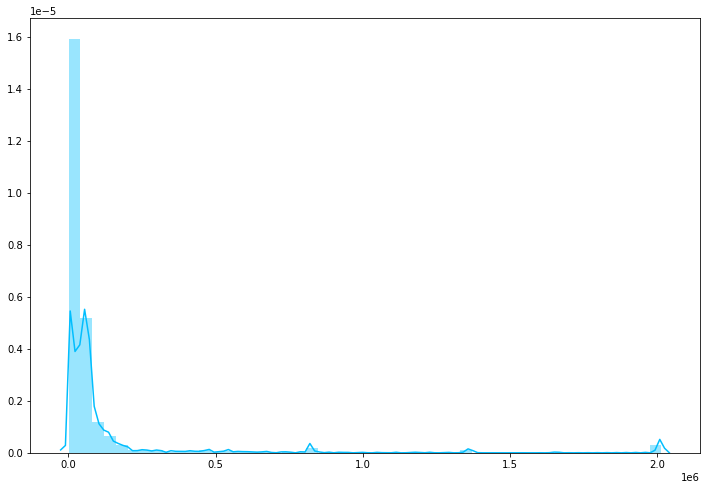

In [0]:
predictions_test, pred_losses_test = predict(model, test)
sns.distplot(pred_losses_test, bins=50, kde=True)

Finally, we can count the number of examples above the threshold (considered as anomalies):

In [0]:
correct = sum(l > THRESHOLD for l in pred_losses_test)
print(f'Correct anomaly predictions: {correct}/{len(test)}')

Correct anomaly predictions: 261/2511


# Clustering
Clustering is used for anomaly detection to learn the normal observations in the training data and then be able to point out on the test set the observations that don't belong to the cluster and which are then considered as outliers.

## Elbow methods (kmeans Clustering)
We group together the usual combination of signals. The points that are far from the cluster are anomalies. So first we have to define the number of clusters. We should either obtain 1 cluster (if there are no anomalies) or 2 clusters if there are.

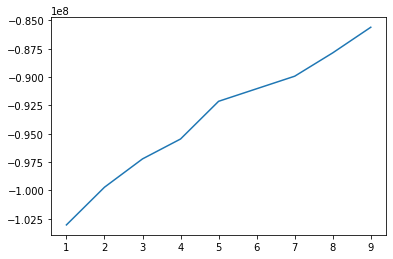

In [0]:
# calculate with different number of centroids to see the loss plot (elbow method)
n_cluster = range(1, 10)
kmeans = [KMeans(n_clusters=i).fit(data) for i in n_cluster]
scores = [kmeans[i].score(data) for i in range(len(kmeans))]
fig, ax = plt.subplots()
ax.plot(n_cluster, scores)
plt.show()

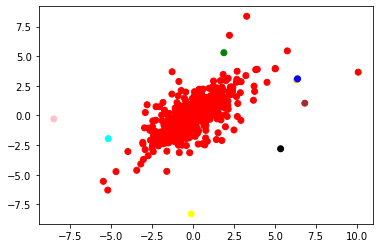

0    1669
8       1
7       1
6       1
5       1
4       1
3       1
2       1
1       1
Name: cluster, dtype: int64

In [0]:
data['cluster'] = kmeans[8].predict(data)
data['principal_feature1'] = data[0]
data['principal_feature2'] = data[1]

fig, ax = plt.subplots()
col = {0:'red', 1:'blue', 2:'green', 3:'pink', 4:'black', 5:'orange', 6:'cyan', 7:'yellow', 8:'brown', 9:'purple', 10:'gold', 11: 'grey', 12:'lightblue', 13:'lightgreen', 14: 'darkgrey'}
ax.scatter(data['principal_feature1'], data['principal_feature2'], c=data["cluster"].apply(lambda x: col[x]))
plt.show()

data['cluster'].value_counts()

In [0]:
# I chose 2 centroids arbitrarily and added this data to the central dataframe
data['cluster'] = kmeans[1].predict(data)
data['principal_feature1'] = data[0]
data['principal_feature2'] = data[1]
data['cluster'].value_counts()

0    1676
1       1
Name: cluster, dtype: int64

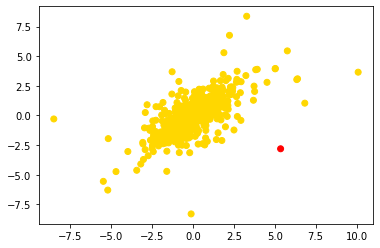

In [0]:
#plot the different clusters with the 2 main features
fig, ax = plt.subplots()
col = {0:'gold', 1:'red', 2:'blue'}
ax.scatter(data['principal_feature1'], data['principal_feature2'], c=data["cluster"].apply(lambda x: col[x]))
plt.show()

We can observe that there is no need to have many centroids, because there are no anomalies in the train set.

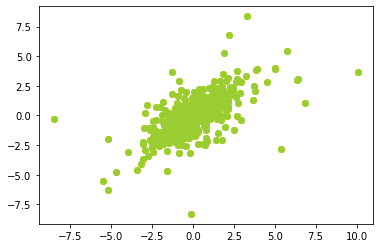

In [0]:
fig, ax = plt.subplots()
for c in colors.cnames:
  ax.scatter(data['principal_feature1'], data['principal_feature2'], c=c)
plt.show()

In [0]:
def getDistanceByPoint(data, model):
    distance = pd.DataFrame()
    for i in range(0,len(data)):
        Xa = np.array(data.loc[i])
        Xb = model.cluster_centers_[model.labels_[i]]
        norm = np.linalg.norm(Xa-Xb)
        distance[i]=norm
    return distance

In [0]:
outliers_fraction = 0.01

distance = getDistanceByPoint(data, kmeans[2])
number_of_outliers = int(outliers_fraction*len(distance))
print('number_of_outliers: ',number_of_outliers)

threshold = distance.nlargest(number_of_outliers, distance).min()

number_of_outliers:  0



> *   We notice that there is **no outlier** or anomaly **in the train** set.


### HDBSCAN / DBSCAN 

DBSCAN is a clustering algorithm that looks for high density regions and groups them into clusters, whereas points in less dense areas are labeled as anomalies.



In [0]:
min_max_scaler = preprocessing.StandardScaler()

np_scaled = min_max_scaler.fit_transform(xtrain)
xtrain = pd.DataFrame(np_scaled)

In [0]:
xtest = min_max_scaler.transform(xtest)
xtest = pd.DataFrame(xtest)

In [0]:
indices=list(range(0,xtrain.shape[1], 1024))

In [0]:
init_train=pd.DataFrame()
init_test=pd.DataFrame()

# train
for i in indices:
    init_train[str(i)]=xtrain.iloc[:,i:(i+1024)].mean(axis=1)

for i in indices:
    init_train[str(2*max(indices)+i)]=xtrain.iloc[:,i:(i+1024)].std(axis=1)

for i in indices:
    init_train[str(4*max(indices)+i)]=xtrain.iloc[:,i:(i+1024)].quantile(0.975, axis=1)

for i in indices:
    init_train[str(8*max(indices)+i)]=xtrain.iloc[:,i:(i+1024)].quantile(0.025, axis=1)

# test

for i in indices:
    init_test[str(i)]=xtest.iloc[:,i:(i+1024)].mean(axis=1)

for i in indices:
    init_test[str(2*max(indices)+i)]=xtest.iloc[:,i:(i+1024)].std(axis=1)

for i in indices:
    init_test[str(4*max(indices)+i)]=xtest.iloc[:,i:(i+1024)].quantile(0.975, axis=1)

for i in indices:
    init_test[str(8*max(indices)+i)]=xtest.iloc[:,i:(i+1024)].quantile(0.025, axis=1)


In [0]:
step_freq=1024

In [0]:
step=128
indices_rolling=list(range(0,xtrain.shape[1]-1024, step))

Moyenne mobile

In [0]:
for i in indices_rolling:
    init_train[str(i)]=xtrain.iloc[:,i:(i+step_freq)].mean(axis=1)

for i in indices_rolling:
    init_test[str(i)]=xtest.iloc[:,i:(i+step_freq)].mean(axis=1)

#### HDBSCAN

In [0]:
%matplotlib inline
plot_kwds = {'alpha' : 0.5, 's' : 80, 'linewidths':0}

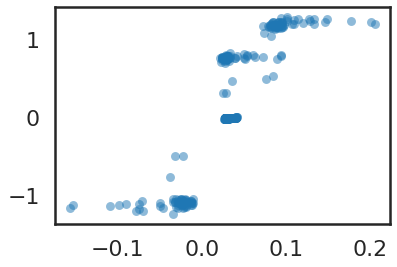

In [0]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=1600, prediction_data=True).fit(init_train)
pal = sns.color_palette('deep', 8)
plt.scatter(init_train.T[0], init_train.T[1], **plot_kwds)

In [0]:
test_labels, strengths = hdbscan.approximate_predict(clusterer, init_test)
test_labels

/usr/local/lib/python3.6/dist-packages/hdbscan/prediction.py:385: UserWarning: Clusterer does not have any defined clusters, new data will be automatically predicted as noise.
  warn('Clusterer does not have any defined clusters, new data'


array([-1, -1, -1, ..., -1, -1, -1], dtype=int32)

In [0]:
class Clusterer(object):

    def predict(self, init_test):
        cl = hdbscan.HDBSCAN(min_samples=1,min_cluster_size=7,cluster_selection_method='leaf',metric='braycurtis')
        clusters = cl.fit_predict(init_test)+1
        return clusters

In [0]:
model = Clusterer()
labels = model.predict(init_test)

In [0]:
print(labels)

[0 0 0 ... 0 0 0]


#### DBSCAN

For detection anomaly problems, DBSCAN packs together points that are close to each other (points with many nearby neighbors). Those which are not packed together and don't have neighbors, are outliers points. It is usually combined with the Gaussian Mixture algorithm or Variational Bayesian Gaussian Mixture.

Our purpose here is to create one cluster (since the train set doesn't contain any outlier). This will allow us to determine the eps parameter to tune our model for one cluster. 

After some trials, we obtain eps= 46 to get 1 cluster of 1 label (normal data).

In [0]:
db = DBSCAN(eps = 49, min_samples=10, n_jobs=-1).fit(init_train)
#pred = db.fit_predict(init_test)

In [0]:
labels_db= db.labels_
print(labels_db)

[0 0 0 ... 0 0 0]


In [0]:
np.sum(labels_db)

0

In [0]:
n_clusters= len(set(labels_db)) - (1 if -1 in labels_db else 0)
print(n_clusters)

1


In [0]:
df = init_test.join(pd.DataFrame(labels_db)).rename(columns={0:'Cluster'})
df.head()

,0,1024,2048,3072,4096,5120,6144,7168,8192,9216,10240,11264,12288,13312,14336,15360,16384,17408,18432,19456,20480,21504,22528,23552,24576,25600,26624,27648,28672,29696,30720,31744,32768,33792,34816,35840,36864,37888,38912,39936,...,54784,54912,55040,55168,55424,55552,55680,55808,55936,56064,56192,56448,56576,56704,56832,56960,57088,57216,57472,57600,57728,57856,57984,58112,58240,58496,58624,58752,58880,59008,59136,59264,59520,59648,59776,59904,60032,60160,60288,Cluster
0,0.815517,0.569260,0.387561,0.255345,0.162608,0.118755,0.018230,-0.012312,-0.016953,-0.060823,-0.108146,-0.088211,-0.031339,0.018261,-0.001778,-0.021981,0.033821,0.024047,0.086940,0.093078,0.037265,-0.020210,-0.029324,-0.034851,-0.003428,0.031276,-0.019736,-0.006631,0.036468,0.039373,-0.013532,-0.017259,0.200603,0.340428,0.272744,0.142312,0.056311,-0.020150,0.009069,0.074084,...,-0.043418,-0.043479,-0.044474,-0.044853,-0.044970,-0.045053,-0.046108,-0.045729,-0.046103,-0.045032,-0.043406,-0.040492,-0.038338,-0.036277,-0.035931,-0.032941,-0.031488,-0.031751,-0.031492,-0.029555,-0.026942,-0.022512,-0.021491,-0.019255,-0.015249,-0.011566,-0.011098,-0.012134,-0.013513,-0.011358,-0.009893,-0.007596,-0.003815,-0.002857,-0.000329,0.001460,0.002417,0.003902,0.005093,0.0
1,-0.070903,-0.064588,-0.057651,-0.059866,-0.063038,-0.068748,-0.045410,-0.037747,-0.039362,-0.040434,-0.033428,-0.046721,-0.038229,-0.035415,-0.045996,-0.054462,-0.056434,-0.051870,-0.050376,-0.066570,-0.054986,-0.041162,-0.049203,-0.056286,-0.047185,-0.045883,-0.053181,-0.062872,-0.063743,-0.044883,-0.042621,-0.046094,-0.063158,-0.065220,-0.060034,-0.054142,-0.061679,-0.054362,-0.050225,-0.053029,...,-0.077151,-0.077803,-0.077574,-0.078288,-0.076045,-0.075909,-0.077685,-0.078201,-0.076492,-0.075345,-0.075866,-0.077072,-0.081347,-0.081660,-0.084338,-0.088580,-0.091862,-0.094032,-0.102568,-0.103291,-0.109163,-0.109102,-0.111233,-0.112144,-0.111430,-0.108256,-0.105638,-0.103040,-0.103121,-0.098992,-0.098129,-0.095719,-0.094541,-0.095099,-0.094626,-0.094152,-0.093125,-0.089854,-0.087679,0.0
2,-0.000382,0.002634,0.004424,-0.003512,-0.000985,-0.002855,-0.036820,-0.049089,-0.062358,-0.082015,-0.054029,-0.041981,-0.056152,-0.077041,-0.003921,-0.059063,-0.038235,-0.077532,-0.037367,-0.073744,-0.065753,-0.040105,-0.049043,-0.054857,-0.058159,-0.066316,-0.074999,-0.051926,-0.063989,-0.012156,-0.081607,-0.056782,-0.039464,-0.049520,-0.073809,-0.038138,-0.061818,-0.056935,-0.087769,-0.059461,...,0.010800,0.008060,0.014491,0.012382,0.016155,0.008411,0.006904,0.007140,0.017817,0.010227,0.004316,0.006838,0.005121,0.009019,0.001227,-0.003149,0.004396,0.002036,0.000982,-0.000412,-0.002633,0.006772,0.005329,0.001518,0.000647,0.005805,-0.000117,-0.000104,-0.004723,-0.003226,-0.007135,0.000062,-0.008075,0.005703,0.000229,-0.000375,0.000802,-0.000637,0.008377,0.0
3,-0.017566,-0.014111,-0.010717,-0.006523,-0.009799,-0.020385,-0.024186,-0.031919,-0.017440,-0.003333,0.007552,0.001320,-0.000418,-0.004811,-0.016390,-0.012162,-0.015358,-0.018140,-0.011422,-0.009519,-0.006214,-0.011387,-0.009412,-0.007932,-0.007014,-0.008377,-0.006139,-0.005530,-0.006004,-0.010314,-0.010242,-0.011659,-0.011237,-0.012836,-0.014405,-0.011434,-0.012156,-0.017314,-0.010242,-0.017445,...,-0.114146,-0.120069,-0.126730,-0.137650,-0.152114,-0.154079,-0.162606,-0.159448,-0.164429,-0.161683,-0.159131,-0.145159,-0.138699,-0.126759,-0.122401,-0.109297,-0.104924,-0.097944,-0.088064,-0.084769,-0.081420,-0.077901,-0.080719,-0.078680,-0.077905,-0.078615,-0.074206,-0.074360,-0.070265,-0.064716,-0.058351,-0.054737,-0.045086,-0.044794,-0.038958,-0.036503,-0.031851,-0.033915,-0.029705,0.0
4,-0.024502,-0.028918,-0.026353,-0.022238,-0.022444,-0.022575,-0.019658,-0.022916,-0.021040,-0.017571,-0.019119,-0.020707,-0.019809,-0.014059,-0.017378,-0.017325,-0.029342,-0.030895,-0.025224,-0.027642,-0.025604,-0.029391,-0.025380,-0.027962,-0.026371,-0.027099,-0.028446,-0.035624,-0.026129,-0.022142,-0.029266,-0.028686,-0.026872,-0.027237,-0.025470,-0.026062,-0.028120,-0.025789,-0.

In [0]:
df_clusters = df.groupby('Cluster').count()
df_clusters

,0,1024,2048,3072,4096,5120,6144,7168,8192,9216,10240,11264,12288,13312,14336,15360,16384,17408,18432,19456,20480,21504,22528,23552,24576,25600,26624,27648,28672,29696,30720,31744,32768,33792,34816,35840,36864,37888,38912,39936,...,54656,54784,54912,55040,55168,55424,55552,55680,55808,55936,56064,56192,56448,56576,56704,56832,56960,57088,57216,57472,57600,57728,57856,57984,58112,58240,58496,58624,58752,58880,59008,59136,59264,59520,59648,59776,59904,60032,60160,60288
Cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0.0,1677,1677,1677,1677,1677,1677,1677,1677,1677,1677,1677,1677,1677,1677,1677,1677,1677,1677,1677,1677,1677,1677,1677,1677,1677,1677,1677,1677,1677,1677,1677,1677,1677,1677,1677,1677,1677,1677,1677,1677,...,1677,1677,1677,1677,1677,1677,1677,1677,1677,1677,1677,1677,1677,1677,1677,1677,1677,1677,1677,1677,1677,1677,1677,1677,1677,1677,1677,1677,1677,1677,1677,1677,1677,1677,1677,1677,1677,1677,1677,1677


#### Describe table + PCA + DBSCAN 

In [0]:
# percentile list 
perc =[.025, 0.975] 
# list of dtypes to include 
include =['float', 'int'] 
# calling describe method 
desc_train = df.describe(percentiles = perc, include = include) 

# display 
desc_train

,0,1024,2048,3072,4096,5120,6144,7168,8192,9216,10240,11264,12288,13312,14336,15360,16384,17408,18432,19456,20480,21504,22528,23552,24576,25600,26624,27648,28672,29696,30720,31744,32768,33792,34816,35840,36864,37888,38912,39936,...,54784,54912,55040,55168,55424,55552,55680,55808,55936,56064,56192,56448,56576,56704,56832,56960,57088,57216,57472,57600,57728,57856,57984,58112,58240,58496,58624,58752,58880,59008,59136,59264,59520,59648,59776,59904,60032,60160,60288,Cluster
count,2511.000000,2511.000000,2511.000000,2511.000000,2511.000000,2511.000000,2511.000000,2511.000000,2511.000000,2511.000000,2511.000000,2511.000000,2511.000000,2511.000000,2511.000000,2511.000000,2511.000000,2511.000000,2511.000000,2511.000000,2511.000000,2511.000000,2511.000000,2511.000000,2511.000000,2511.000000,2511.000000,2511.000000,2511.000000,2511.000000,2511.000000,2511.000000,2511.000000,2511.000000,2511.000000,2511.000000,2511.000000,2511.000000,2511.000000,2511.000000,...,2511.000000,2511.000000,2511.000000,2511.000000,2511.000000,2511.000000,2511.000000,2511.000000,2511.000000,2511.000000,2511.000000,2511.000000,2511.000000,2511.000000,2511.000000,2511.000000,2511.000000,2511.000000,2511.000000,2511.000000,2511.000000,2511.000000,2511.000000,2511.000000,2511.000000,2511.000000,2511.000000,2511.000000,2511.000000,2511.000000,2511.000000,2511.000000,2511.000000,2511.000000,2511.000000,2511.000000,2511.000000,2511.000000,2511.000000,1677.0
mean,-0.762414,-0.731472,-0.731144,-0.748678,-0.732236,-0.745339,-0.760112,-0.765096,-0.742544,-0.754022,-0.746081,-0.754022,-0.748016,-0.750927,-0.757805,-0.776478,-0.764603,-0.747785,-0.744477,-0.759631,-0.757618,-0.741572,-0.763773,-0.749681,-0.749724,-0.756381,-0.747968,-0.728791,-0.708101,-0.717475,-0.711272,-0.718391,-0.727609,-0.710376,-0.702698,-0.700985,-0.688937,-0.704955,-0.710163,-0.726143,...,-0.760648,-0.766248,-0.770017,-0.771623,-0.773056,-0.774058,-0.778205,-0.780724,-0.783162,-0.785416,-0.787935,-0.782275,-0.780774,-0.778209,-0.774442,-0.770828,-0.768329,-0.766852,-0.768599,-0.767812,-0.767368,-0.768013,-0.768251,-0.769014,-0.766760,-0.767269,-0.770074,-0.770736,-0.770326,-0.773108,-0.775489,-0.779683,-0.784726,-0.788510,-0.793580,-0.799767,-0.802994,-0.806909,-0.809376,0.0
std,5.196600,5.179237,5.119450,5.103612,5.192713,5.049527,5.045727,5.071613,5.082618,5.035720,5.027056,5.047583,5.001720,4.981331,5.068694,5.063068,5.047026,5.029303,4.951979,5.031848,4.982290,5.002971,5.073166,5.125513,5.086902,5.034035,4.845264,4.796559,4.685000,4.751413,4.812008,4.763980,4.767157,4.797815,4.749911,4.824548,4.834764,4.851998,4.873553,4.977240,...,5.087164,5.121290,5.155569,5.174862,5.205032,5.205251,5.222850,5.233207,5.237608,5.244184,5.240898,5.214742,5.223940,5.225794,5.213615,5.206190,5.199520,5.178816,5.144990,5.134131,5.115117,5.117761,5.118314,5.109692,5.111484,5.125681,5.120223,5.123707,5.110357,5.114342,5.126081,5.133240,5.173749,5.199779,5.229104,5.258288,5.271626,5.289473,5.306505,0.0
min,-37.523526,-36.951633,-36.767295,-36.890260,-37.043299,-36.640604,-36.658083,-36.837526,-36.632587,-36.612544,-36.468496,-36.361215,-36.003893,-35.974002,-36.566964,-36.717754,-36.546192,-36.215175,-35.642560,-36.124752,-35.969531,-35.967651,-36.544689,-36.586921,-36.341669,-36.042083,-34.941631,-34.367215,-33.705327,-34.079091,-34.189783,-34.043239,-34.313799,-34.300626,-34.053668,-34.376312,-34.240583,-34.678434,-34.885824,-35.663533,...,-36.388385,-36.598725,-36.809338,-36.909428,-36.981381,-36.961075,-37.068286,-37.135684,-37.190187,-37.266589,-37.317116,-37.165651,-37.215818,-37.198672,-37.086368,-36.980469,-36.887910,-36.767680,-36.618319,-36.558379,-36.460157,-36.467615,-36.469578,-36.441403,-36.450251,-36.562231,-36.594577,-36.646857,-36.583047,-36.647638,-36.735648,-36.816290,-37.074127,-37.209647,-37.380032,-37.590304,-37.673100,-37.785093,-37.876618,0.0
2.5%,-15.301431,-15.067492,-14.992209,-15.041559,-15.105228,-14.941786,-14.948730,-15.021059,-14.938047,-14.928348,-14.869868,-14.825395,-14.678974,-14.66

In [0]:
# PCA transform
pca1 = PCA(n_components = 8, whiten = True)
pca1.fit(desc_train)
xtrain_fpca = pca1.fit_transform(desc_train)
# Fit the low-dimensional method
lof1 = LocalOutlierFactor(n_neighbors = 1 ,contamination = 'auto', novelty = True)
lof1.fit(xtrain_fpca)
# Calculate anomaly score on the (PCA-transformed) test data
xtest_fpca = pca1.fit_transform(init_test)
dbscan_pca = -lof1.score_samples(xtest_fpca)

#### PCA + DBSCAN + Isolation forest

In [0]:
data = pd.DataFrame(xtrain_fpca)
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)

outliers_fraction = 0.01
# train isolation forest 
model_if =  IsolationForest(contamination = outliers_fraction)
model_if.fit(data)
# add the data to the main  
data['anomaly2'] = pd.Series(model_if.predict(data))
data['anomaly2'] = data['anomaly2'].map( {1: 0, -1: 1} )
print(data['anomaly2'].value_counts())

0    7
1    1
Name: anomaly2, dtype: int64


In [0]:
# Calculate anomaly score on the (Isolation-Forest-transformed) test data
model_if.fit(init_test)
ift_dbscan = -model_if.score_samples(init_test)
ift_dbscan = pd.Series(ift_dbscan).apply(math.exp)
print(ift_dbscan[:])
np.savetxt(path+'scores/ift_dbscan.csv', ift_dbscan, fmt = '%1.6f', delimiter=',')

0       1.379537
1       1.371170
2       1.393040
3       1.368151
4       1.359121
          ...   
2506    2.081362
2507    1.968560
2508    1.379630
2509    1.363424
2510    1.474049
Length: 2511, dtype: float64


### Models Perormance Summary:

---

NB: We trained on the init_train and init_test

| Algorithm  | **Score** |
| --- | --- |
| HDBSCAN| 0.5 |
| DBSCAN| 0.512552992943 |
| DBSCAN / PCA | 0.57767869282 |
| DBSCAN /PCA / Isolation Forest |0.654160023237 |

# Data augmentation
## Synthetic Minority Oversampling Technique (SMOTE)

We noticed at the beginning that our train set doesn't contain any anomaly. We can consider this problem as an unbalanced binary classification problem with an unbalanced train set containing too few observations of the minority class (the anomalies) and a majority of normal observations.

We can try to  balance the distribution by creating synthetic anomalies in the train set.

We will use the so-called Synthetic Minority Oversampling TEchnique, described by Nitesh Chawla, et al. in their 2002 paper named for the technique titled “SMOTE: Synthetic Minority Over-sampling Technique.”

#### PCA + One Class SVM + SMOTE approach

(1677, 10)
0    1654
1      23
Name: anomaly, dtype: int64


0    1654
1      23
Name: anomaly, dtype: int64

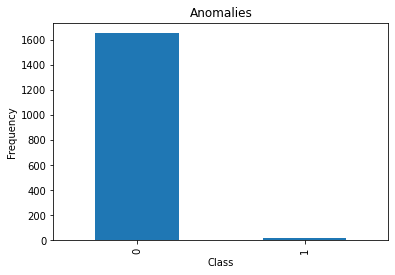

In [0]:
# train one class SVM 
data1 = data.copy()
print(data1.shape)
outliers_fraction = 0.01
ocs =  OneClassSVM(nu=0.91 * outliers_fraction)
ocs.fit(data1)
# add the data to the main  
data1['anomaly'] = pd.Series(ocs.predict(data))
data1['anomaly'] = data1['anomaly'].map( {1: 0, -1: 1} )

# visualisation
pd.value_counts(data1['anomaly']).plot.bar()
plt.title('Anomalies')
plt.xlabel('Class')
plt.ylabel('Frequency')
data1['anomaly'].value_counts()

As we can see here, the anomalies are a minority in our train set. We confirm that our training set is unbalanced (nearly doesn't contain any anomaly).

### SMOTE then Logistic Regression & Grid Search

In [0]:
xtrain_smote = data1.drop(data1['anomaly'],axis=1)
ytrain_smote = data1['anomaly']

In [0]:
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_sample(xtrain_smote, ytrain_smote)

print("Before OverSampling, counts of label '1': {}".format(sum(ytrain_smote==1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(ytrain_smote==0)))

print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape))

print("After OverSampling, counts of label '1': {}".format(sum(y_train_res==1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res==0)))

Before OverSampling, counts of label '1': 23
Before OverSampling, counts of label '0': 1654 

After OverSampling, the shape of train_X: (3308, 9)
After OverSampling, the shape of train_y: (3308,) 

After OverSampling, counts of label '1': 1654
After OverSampling, counts of label '0': 1654


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


(2511, 10)


0    2472
1      39
Name: anomaly, dtype: int64

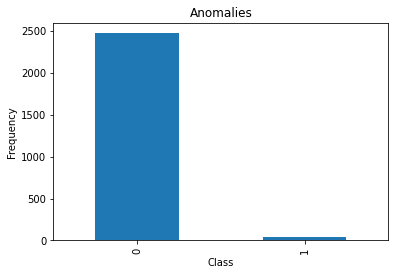

In [0]:
# test one class SVM 
np_scaled = min_max_scaler.fit_transform(xtest_fpca)
test_pca = pd.DataFrame(np_scaled)
test1 = test_pca.copy()

print(test1.shape)

outliers_fraction = 0.01
ocs =  OneClassSVM(nu=0.91 * outliers_fraction)
ocs.fit(test1)
# add the data to the main  
test1['anomaly'] = pd.Series(ocs.predict(test1))
test1['anomaly'] = test1['anomaly'].map( {1: 0, -1: 1} )

# visualisation
pd.value_counts(test1['anomaly']).plot.bar()
plt.title('Anomalies')
plt.xlabel('Class')
plt.ylabel('Frequency')
test1['anomaly'].value_counts()

In [0]:
xtest_smote = test1.drop(test1['anomaly'],axis=1)
ytest_smote = test1['anomaly']

In [0]:
X_test_res, y_test_res = sm.fit_sample(xtest_smote, ytest_smote)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Now that we have obtained a more balanced data set, we can use a classical classifier like a logistic regression.

In [0]:
parameters = {
    'C': np.linspace(1, 10, 10)
             }
lr = LogisticRegression()
clf = GridSearchCV(lr, parameters, cv=5, verbose=5, n_jobs=3)
clf.fit(X_train_res, y_train_res.ravel())

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  12 tasks      | elapsed:    0.9s
[Parallel(n_jobs=3)]: Done  50 out of  50 | elapsed:    1.1s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=3,
             param_grid={'C': array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=5)

In [0]:
clf.best_params_

{'C': 1.0}

In [0]:
l2 = LogisticRegression(C=4,penalty='l2', verbose=5)
l2.fit(X_train_res, y_train_res.ravel())

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


LogisticRegression(C=4, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=5,
                   warm_start=False)

Recall metric in the train dataset: 100.0%


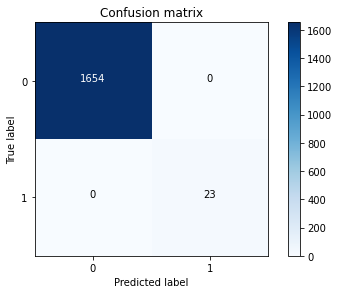

In [0]:
y_train_pre = l2.predict(xtrain_smote)
cnf_matrix_tra = confusion_matrix(ytrain_smote, y_train_pre)
print("Recall metric in the train dataset: {}%".format(100*cnf_matrix_tra[1,1]/(cnf_matrix_tra[1,0]+cnf_matrix_tra[1,1])))
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix_tra , classes=class_names, title='Confusion matrix')
plt.show()

In [0]:
tmp = l2.fit(X_train_res, y_train_res.ravel())

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Recall metric in the testing dataset: 92.3076923076923%


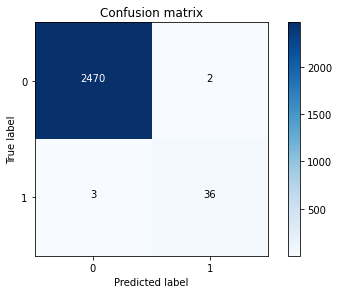

In [0]:
y_pre = l2.predict(xtest_smote)
cnf_matrix = confusion_matrix(ytest_smote, y_pre)

print("Recall metric in the testing dataset: {}%".format(100*cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1])))
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix , classes=class_names, title='Confusion matrix')
plt.show()

Now that the labels are available, we can use classical ways to evaluate the
quality of an anomaly scoring function which are ROC and PR
curves.

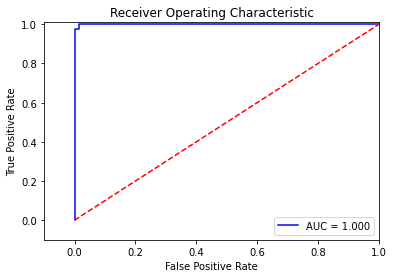

In [0]:
y_pred_sample_score = tmp.decision_function(xtest_smote)

fpr, tpr, thresholds = roc_curve(ytest_smote, y_pred_sample_score)

roc_auc = auc(fpr,tpr)

# Plot ROC
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label='AUC = %0.3f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.0])
plt.ylim([-0.1,1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [0]:
roc_auc

0.999553978922911

## GRU
Gated Recurrent Unit (GRU) cells are employed to discover the correlations among time sequences.
#### GRU architecture

In [0]:
train = np.reshape(data.to_numpy(), (obs, 1, entries))
test = np.reshape(xtest.to_numpy(), (xtest.shape[0], 1, xtest.shape[1]))

In [0]:
regressorGRU = Sequential()
# 1st GRU layer with Dropout regularisation
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(1, entries), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# 2nd GRU layer
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(1, entries), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# 3rd GRU layer
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(1, entries), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# 4th GRU layer
regressorGRU.add(GRU(units=50, input_shape=(1, entries), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# The output layer
regressorGRU.add(Dense(units=1))

#####  Compiling and fitting


In [0]:
# Compiling the RNN
regressorGRU.compile(optimizer="adam",loss='mean_squared_error')
# Fitting to the training set
regressorGRU.fit(train,ytrain, epochs=50,batch_size=32)

Epoch 1/50
1677/1677 [==============================] - 4s 2ms/step - loss: 0.3434
Epoch 2/50
1677/1677 [==============================] - 3s 2ms/step - loss: 0.0498
Epoch 3/50
1677/1677 [==============================] - 3s 2ms/step - loss: 0.0287
Epoch 4/50
1677/1677 [==============================] - 3s 2ms/step - loss: 0.0184
Epoch 5/50
1677/1677 [==============================] - 3s 2ms/step - loss: 0.0141
Epoch 6/50
1677/1677 [==============================] - 3s 2ms/step - loss: 0.0112
Epoch 7/50
1677/1677 [==============================] - 3s 2ms/step - loss: 0.0088
Epoch 8/50
1677/1677 [==============================] - 3s 2ms/step - loss: 0.0084
Epoch 9/50
1677/1677 [==============================] - 3s 2ms/step - loss: 0.0075
Epoch 10/50
1677/1677 [==============================] - 3s 2ms/step - loss: 0.0070
Epoch 11/50
1677/1677 [==============================] - 3s 2ms/step - loss: 0.0066
Epoch 12/50
1677/1677 [==============================] - 3s 2ms/step - loss: 0.0061
E

In [0]:
#score_gru = abs(1-predict)+1
score_gru = abs(1-predict)

In [0]:
test_predict = regressorGRU.predict(test)

> * We obtain a score of : 0.364546639969

# Ensemble models (mixing best models)

We will try now to aggregate the models that worked well and evaluate the performance of combining the best of them.

### SMOTE + PCA + Isolation forest
We use a min-max-scaler and train an isolation forest model on the train set obtained by SMOTE with applying a PCA.

In [0]:
# train isolation forest 
model_if =  IsolationForest(contamination = outliers_fraction)
model_if.fit(xtrain_smote)
# add the data to the main  
xtrain_smote['anomaly2'] = pd.Series(model_if.predict(xtrain_smote))
xtrain_smote['anomaly2'] = xtrain_smote['anomaly2'].map( {1: 0, -1: 1} )
print(xtrain_smote['anomaly2'].value_counts())

0    1660
1      17
Name: anomaly2, dtype: int64
(1677, 10)
(2511, 10)


In [0]:
# Calculate anomaly score on the (Isolation-Forest-transformed) test data
np_scaled = min_max_scaler.fit_transform(xtest_fpca)
test_pca = pd.DataFrame(np_scaled)
test1 = test_pca.copy()
print(test1.shape)

xtest_if = model_if.fit(test1)
score_pca_if_smote = -model_if.score_samples(test1)

(2511, 10)


In [0]:
print(score_pca_if_smote[:])

[0.33554121 0.29904577 0.30309115 ... 0.32021719 0.30520678 0.36699884]


> * The score is **0.685275995897**

#### Isolation forest after xtest_smote

In [0]:
# Calculate anomaly score on the (Isolation-Forest-transformed) test data
np_scaled = min_max_scaler.fit_transform(xtest_smote)
test_pca = pd.DataFrame(np_scaled)
test2 = test_pca.copy()
print(test2.shape)

xtest_if = model_if.fit(test2)

pca_if_smote2 = -model_if.score_samples(test2)

(2511, 9)


In [0]:
print(pca_if_smote[:])

[0.36745242 0.29851582 0.30156004 ... 0.31892169 0.30715565 0.36479907]


In [0]:
# add the data to the main  
xtest_smote['anomaly2'] = pd.Series(model_if.predict(xtest_smote))
xtest_smote['anomaly2'] = xtest_smote['anomaly2'].map( {1: 0, -1: 1} )
print(xtest_smote['anomaly2'].value_counts())
xtest_if2 = model_if.fit(test2)

pca_if_smote22 = -model_if.score_samples(test2)

0    2494
1      17
Name: anomaly2, dtype: int64


> * We obtain a score of **0.687999802242**

### SMOTE + GRU !
we apply a smote to generate synthetic anomalies and we obtain a larger dataset. After that we apply a GRU on the sequences of the new xtrain_smote.

In [0]:
train = np.reshape(xtrain_smote.to_numpy(), (xtrain_smote.shape[0], 1, xtrain_smote.shape[1]))
test = np.reshape(xtest_smote.to_numpy(), (xtest_smote.shape[0], 1, xtest_smote.shape[1]))

In [0]:
obs = xtrain_smote.shape[0]
entries = xtrain_smote.shape[1]

In [0]:
regressorGRU = Sequential()
# 1st GRU layer with Dropout regularisation
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(1, entries), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# 2nd GRU layer
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(1, entries), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# 3rd GRU layer
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(1, entries), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# 4th GRU layer
regressorGRU.add(GRU(units=50, input_shape=(1, entries), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# The output layer
regressorGRU.add(Dense(units=1))

In [0]:
# Compiling the RNN
regressorGRU.compile(optimizer="adam",loss='mean_squared_error')
# Fitting to the training set
regressorGRU.fit(train, ytrain, epochs=50,batch_size=32)

Epoch 1/50
1677/1677 [==============================] - 2s 1ms/step - loss: 0.4335
Epoch 2/50
1677/1677 [==============================] - 1s 502us/step - loss: 0.0174
Epoch 3/50
1677/1677 [==============================] - 1s 510us/step - loss: 0.0126
Epoch 4/50
1677/1677 [==============================] - 1s 506us/step - loss: 0.0114
Epoch 5/50
1677/1677 [==============================] - 1s 503us/step - loss: 0.0114
Epoch 6/50
1677/1677 [==============================] - 1s 490us/step - loss: 0.0099
Epoch 7/50
1677/1677 [==============================] - 1s 494us/step - loss: 0.0092
Epoch 8/50
1677/1677 [==============================] - 1s 490us/step - loss: 0.0084
Epoch 9/50
1677/1677 [==============================] - 1s 495us/step - loss: 0.0084
Epoch 10/50
1677/1677 [==============================] - 1s 499us/step - loss: 0.0074
Epoch 11/50
1677/1677 [==============================] - 1s 487us/step - loss: 0.0076
Epoch 12/50
1677/1677 [==============================] - 1s 487us

In [0]:
#score_gru = abs(1-predict)+1
gru2_predict = regressorGRU.predict(test)
gru2_score = abs(1-gru2_predict)

We Obtain a score of **0.573261584288**.

### Models Perormance Summary:

---


| Algorithm  | **Score** |
| --- | --- |
| SMOTE + GRU| 0.573261584288 |
| pca + smote + one class svm | 0.519337016575|
| pca + smote + isolation forest|0.687999802242|
| pca + smote + one class svm + if| 0.685275995897 |



### Descriptive statistics + GRU

In [0]:
# percentile list 
perc =[.01, 0.99] 

# list of dtypes to include 
include =['float', 'int'] 

# calling describe method 
desc_train = xtrain.describe(percentiles = perc, include = include) 

# display 
desc_train

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,61400,61401,61402,61403,61404,61405,61406,61407,61408,61409,61410,61411,61412,61413,61414,61415,61416,61417,61418,61419,61420,61421,61422,61423,61424,61425,61426,61427,61428,61429,61430,61431,61432,61433,61434,61435,61436,61437,61438,61439
count,1.677000e+03,1.677000e+03,1.677000e+03,1.677000e+03,1.677000e+03,1.677000e+03,1.677000e+03,1.677000e+03,1.677000e+03,1.677000e+03,1.677000e+03,1.677000e+03,1.677000e+03,1.677000e+03,1.677000e+03,1.677000e+03,1.677000e+03,1.677000e+03,1.677000e+03,1.677000e+03,1.677000e+03,1.677000e+03,1.677000e+03,1.677000e+03,1.677000e+03,1.677000e+03,1.677000e+03,1.677000e+03,1.677000e+03,1.677000e+03,1.677000e+03,1.677000e+03,1.677000e+03,1.677000e+03,1.677000e+03,1.677000e+03,1.677000e+03,1.677000e+03,1.677000e+03,1.677000e+03,...,1.677000e+03,1.677000e+03,1.677000e+03,1.677000e+03,1.677000e+03,1.677000e+03,1.677000e+03,1.677000e+03,1.677000e+03,1.677000e+03,1.677000e+03,1.677000e+03,1.677000e+03,1.677000e+03,1.677000e+03,1.677000e+03,1.677000e+03,1.677000e+03,1.677000e+03,1.677000e+03,1.677000e+03,1.677000e+03,1.677000e+03,1.677000e+03,1.677000e+03,1.677000e+03,1.677000e+03,1.677000e+03,1.677000e+03,1.677000e+03,1.677000e+03,1.677000e+03,1.677000e+03,1.677000e+03,1.677000e+03,1.677000e+03,1.677000e+03,1.677000e+03,1.677000e+03,1.677000e+03
mean,-4.084720e-17,-2.564122e-17,-3.166569e-17,-8.726373e-18,-8.440873e-19,-9.661489e-19,-1.368745e-17,-4.729371e-18,1.096176e-17,1.001733e-17,2.192144e-17,-1.386124e-17,6.181698e-18,-8.689134e-18,-1.308335e-17,-1.891749e-17,-2.841347e-17,-5.157104e-17,-4.267399e-17,4.827848e-17,3.169465e-17,2.073807e-17,-5.817582e-18,-1.504048e-17,4.734543e-18,-8.639481e-18,-2.681632e-17,3.970520e-17,-6.167630e-17,1.467222e-17,1.991880e-17,-1.156896e-17,-2.391581e-17,2.476817e-17,1.126277e-17,6.703046e-18,3.446690e-17,1.084073e-18,-8.705684e-18,-1.118416e-17,...,-4.882466e-18,-6.223075e-18,1.074970e-17,-3.427656e-17,5.714967e-17,-1.242960e-17,-8.676721e-18,-2.003052e-17,-8.163648e-18,2.627429e-17,-2.697769e-17,-3.078436e-18,7.944351e-18,-2.540537e-18,6.959582e-18,-1.464740e-17,-1.760170e-17,3.905972e-18,4.137683e-20,-3.746258e-17,4.329671e-17,3.593164e-17,-1.003802e-17,3.384624e-18,1.652590e-17,-2.022499e-17,-2.188834e-17,-3.039542e-17,-4.290777e-18,-1.190825e-17,-5.742276e-17,3.782670e-17,2.627429e-17,1.242132e-17,-2.821072e-17,-2.773902e-17,-1.415087e-18,-4.807987e-18,1.800720e-17,-2.304689e-17
std,1.000298e+00,1.000298e+00,1.000298e+00,1.000298e+00,1.000298e+00,1.000298e+00,1.000298e+00,1.000298e+00,1.000298e+00,1.000298e+00,1.000298e+00,1.000298e+00,1.000298e+00,1.000298e+00,1.000298e+00,1.000298e+00,1.000298e+00,1.000298e+00,1.000298e+00,1.000298e+00,1.000298e+00,1.000298e+00,1.000298e+00,1.000298e+00,1.000298e+00,1.000298e+00,1.000298e+00,1.000298e+00,1.000298e+00,1.000298e+00,1.000298e+00,1.000298e+00,1.000298e+00,1.000298e+00,1.000298e+00,1.000298e+00,1.000298e+00,1.000298e+00,1.000298e+00,1.000298e+00,...,1.000298e+00,1.000298e+00,1.000298e+00,1.000298e+00,1.000298e+00,1.000298e+00,1.000298e+00,1.000298e+00,1.000298e+00,1.000298e+00,1.000298e+00,1.000298e+00,1.000298e+00,1.000298e+00,1.000298e+00,1.000298e+00,1.000298e+00,1.000298e+00,1.000298e+00,1.000298e+00,1.000298e+00,1.000298e+00,1.000298e+00,1.000298e+00,1.000298e+00,1.000298e+00,1.000298e+00,1.000298e+00,1.000298e+00,1.000298e+00,1.000298e+00,1.000298e+00,1.000298e+00,1.000298e+00,1.000298e+00,1.000298e+00,1.000298e+00,1.000298e+00,1.000298e+00,1.000298e+00
min,-8.486273e+00,-8.304330e+00,-1.030046e+01,-9.495531e+00,-9.233733e+00,-7.948523e+00,-8.894341e+00,-9.230001e+00,-8.976582e+00,-8.738036e+00,-7.010542e+00,-9.156327e+00,-1.041628e+01,-1.091729e+01,-7.880294e+00,-8.597045e+00,-8.806711e+00,-1.031621e+01,-7.593853e+00,-9.718152e+00,-1.193232e+01,-1.033376e+01,-9.680646e+00,-8.939732e+00,-7.569504e+00,-9.526666e+00,-1.254720e+01,-1.028321e+01,-7.398151e+00,-1.005722e+01,-1.188909e+01,-1.019795e+

In [0]:
desc_test = xtest.describe(percentiles = perc, include = include)

In [0]:
# PCA transform
pca1 = PCA(n_components = 8, whiten = True)
pca1.fit(desc_train)
xtrain_fpca = pca1.fit_transform(desc_train)
# Fit the low-dimensional method
lof1 = LocalOutlierFactor(n_neighbors = 5 ,contamination = 'auto', novelty = True)
lof1.fit(xtrain_fpca)
# Calculate anomaly score on the (PCA-transformed) test data
xtest_fpca = pca1.fit_transform(xtest)
desc_pca = -lof1.score_samples(xtest_fpca)

array([1., 1., 1., ..., 1., 1., 1.])

> * We obtain a quite interesting score of : **0.61325966**

We decide to move forward with a simple GRU architecture to test if the score improves.

<br>


### Simple GRU architecture (one layer) after PCA

In [0]:
xtrain_fpca_seq = np.reshape(xtrain_fpca, (xtrain_fpca.shape[0], 1, xtrain_fpca.shape[1]))
xtest_fpca_seq = np.reshape(xtest_fpca, (xtest_fpca.shape[0], 1, xtest_fpca.shape[1]))

In [0]:
xtrain_fpca_seq.shape, xtest_fpca_seq.shape

((8, 1, 8), (2511, 1, 8))

In [0]:
model = Sequential()
# 1st GRU layer with Dropout regularisation
model.add(LSTM(units=50,  input_shape=(1,xtrain_fpca.shape[1]), activation='tanh'))
model.add(Dropout(0.2))
# The output layer
model.add(Dense(units=1))

In [0]:
model.compile(optimizer="adam",loss='mean_squared_error')

In [0]:
ytrain_fpca = np.ones(xtrain_fpca_seq.shape[0], dtype=int)

ytrain_fpca = pd.DataFrame(ytrain_fpca)
print('Shape of xtrain : {}'.format(xtrain_fpca_seq.shape))
print('Shape of ytrain: {}'.format(ytrain_fpca.shape))

Shape of xtrain : (8, 1, 8)
Shape of ytrain: (8, 1)


In [0]:
model.fit(xtrain_fpca_seq,ytrain_fpca, epochs=50,batch_size=32)

Epoch 1/50
8/8 [==============================] - 2s 244ms/step - loss: 1.0867
Epoch 2/50
8/8 [==============================] - 0s 1ms/step - loss: 1.0910
Epoch 3/50
8/8 [==============================] - 0s 1ms/step - loss: 1.1088
Epoch 4/50
8/8 [==============================] - 0s 1ms/step - loss: 1.0956
Epoch 5/50
8/8 [==============================] - 0s 1ms/step - loss: 1.0407
Epoch 6/50
8/8 [==============================] - 0s 937us/step - loss: 1.0050
Epoch 7/50
8/8 [==============================] - 0s 934us/step - loss: 1.0409
Epoch 8/50
8/8 [==============================] - 0s 978us/step - loss: 1.0124
Epoch 9/50
8/8 [==============================] - 0s 1ms/step - loss: 0.9848
Epoch 10/50
8/8 [==============================] - 0s 921us/step - loss: 1.0761
Epoch 11/50
8/8 [==============================] - 0s 874us/step - loss: 0.9839
Epoch 12/50
8/8 [==============================] - 0s 863us/step - loss: 0.9805
Epoch 13/50
8/8 [==============================] - 0s 911us

In [0]:
predict_fpca_seq = model.predict(xtest_fpca_seq)

In [0]:
scores_fpca_seq = abs(1-pd.Series([i[0] for i in predict_fpca_seq])).apply(math.exp)

> **Of course this doesn't give a great score (0.441159294004) which makes sense since the PCA removes the sequential aspect of the time series, that the GRU needs to perform well.**

Here is a summary of the scores obtained:

<br>

### Models Perormance Summary:

---

| Algorithm  | **Score** |
| --- | --- |
| One layer GRU on describe / PCA | 0.613259668508 |
| One layer GRU on descibe ps exp(abs(1-scr)) | **0.711230177859**|
| One layer GRU / One class svm | 0.668974872384 |


### Let's build our own descriptive statistics table !
We decide to build our own train and test tables using taking into account the most relevant descriptive statistics. Below the architecture of our new init_train and init_test.

In [0]:
indices=list(range(0,xtrain.shape[1], 1024))
init_train=pd.DataFrame()
init_test=pd.DataFrame()

In [0]:
for i in indices:
    init_train[str(i)]=xtrain.iloc[:,i:(i+1024)].mean(axis=1)
for i in indices:
    init_train[str(2*max(indices)+i)]=xtrain.iloc[:,i:(i+1024)].std(axis=1)
for i in indices:
    init_train[str(4*max(indices)+i)]=xtrain.iloc[:,i:(i+1024)].quantile(0.975, axis=1)
for i in indices:
    init_train[str(8*max(indices)+i)]=xtrain.iloc[:,i:(i+1024)].quantile(0.025, axis=1)
for i in indices:
    init_test[str(i)]=xtest.iloc[:,i:(i+1024)].mean(axis=1)
for i in indices:
    init_test[str(2*max(indices)+i)]=xtest.iloc[:,i:(i+1024)].std(axis=1)
for i in indices:
    init_test[str(4*max(indices)+i)]=xtest.iloc[:,i:(i+1024)].quantile(0.975, axis=1)
for i in indices:
    init_test[str(8*max(indices)+i)]=xtest.iloc[:,i:(i+1024)].quantile(0.025, axis=1)

In [0]:
train_seq = np.reshape(init_train.to_numpy(), (init_train.shape[0], 1, init_train.shape[1]))
test_seq = np.reshape(init_test.to_numpy(), (init_test.shape[0], 1, init_test.shape[1]))

We apply a PCA and LOF and obtain the following results:

In [0]:
# PCA transform
pca1 = PCA(n_components = 100, whiten = True)
pca1.fit(init_train)
xtrain_fpca = pca1.fit_transform(init_train)
# Fit the low-dimensional method
lof1 = LocalOutlierFactor(n_neighbors =1 ,contamination = 'auto', novelty = True)
lof1.fit(xtrain_fpca)
# Calculate anomaly score on the (PCA-transformed) test data
xtest_fpca = pca1.fit_transform(init_test)
sscore = -lof1.score_samples(xtest_fpca)

### Models Perormance Summary:

---

<br>

*Init_train and init_test are obtained by calculating the mean, std, quartiles 2.5 and 97.5.*



| Algorithm  | **Score** |
| --- | --- |
| exponential(score of init_train & init_test /PCA n_neighbors=1/ LOF ) | 0.369 |
| score of init_train & init_test /PCA n_neighbors=3 / LOF ) | 0.771459824243 |
| **score of init_train & init_test /PCA n_neighbors=1 / LOF )** | **0.775853758018** |

This is the best score obtained.

## References
- Sequential VAE-LSTM for Anomaly
Detection on Time Series https://www.groundai.com/project/sequential-vae-lstm-for-anomaly-detection-on-time-series/1
- https://github.com/albertcthomas/anomaly_tuning/blob/master/demo_anomaly_tuning.ipynb
- https://deepai.org/publication/time-series-anomaly-detection-service-at-microsoft
- [Sequitur - Recurrent Autoencoder (RAE)](https://github.com/shobrook/sequitur)
- [Towards Never-Ending Learning from Time Series Streams](https://www.cs.ucr.edu/~eamonn/neverending.pdf)
- [LSTM Autoencoder for Anomaly Detection](https://towardsdatascience.com/lstm-autoencoder-for-anomaly-detection-e1f4f2ee7ccf)
- [Unsupervised Learning Metrics: github of bstienen](https://github.com/bstienen/unsupervised-learning-metrics)
-Integrated Dimensionality Reduction and Sequence Prediction using LSTM
- J.O. Ramsay, Silverman, B.W. (2005): Functional Data Analysis. Springer-Verlag, New-York.
- Ferraty, F., Vieu, P. (2006): Nonparametric Functional Data Analysis: Theory and Practice. Springer Science & Business Media.
- Chandola, V., Banerjee, A., Kumar, V. (2009): Anomaly detection: A survey. ACM Computing Surveys (CSUR) 41(3), 1-58.
- Hubert, M., Rousseeuw, P.J., Segaert, P. (2015): Multivariate functional outlier detection. Statistical Methods & Applications 24(2), 177-202.
- Wang, J.L., Chiou, J.M., Müller, H.G. (2016): Functional data analysis. Annual Review of Statistics and Its Application 3, 257-295.

Kaggles:
- (https://www.kaggle.com/qianchao/smote-with-imbalance-data)
- https://www.kaggle.com/amirrezaeian/time-series-data-analysis-using-lstm-tutorial
- https://www.kaggle.com/victorambonati/unsupervised-anomaly-detection
- https://www.kaggle.com/kevinelong/unsupervised-anomaly-detection-lumious/code
- https://www.kaggle.com/fatmakursun/predict-sales-time-series-with-cnn
- https://www.kaggle.com/mindcool/hdbscan-clustering-ii
- https://www.kaggle.com/amitkishore/dbscan-kmeans-for-outlier-detection








